In [1]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u



plt.rcParams['pdf.fonttype']=42
ko_mice = stx.ymaze_sess_deets.ko_mice

ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
# ctrl_mice = [m for m in ctrl_mice if m not in ('mCherry6')]

%matplotlib inline

%load_ext autoreload
%autoreload 2

Left to do:

explicit speed matching of formation lap & average speed through field

comparison of COM shift after formation lap (fast shift followed by slow shift)
    looks like initial shift is more dramatic
    
plot speed vs shift conditional distributions
    




In [2]:
figdir = "/mnt/BigDisk/YMazeResults/neural/field_shifts"
os.makedirs(figdir,exist_ok=True)

In [3]:

def run_shuffle(sess, rng, last_block_only=False):
    spks = sess.timeseries['spks']
    spks_shuff = np.zeros(spks.shape)
    
    lr = sess.trial_info['LR']
    
    if last_block_only:
        trial_starts = sess.trial_start_inds[sess.trial_info['block_number']==5]
        teleports = sess.teleport_inds[sess.trial_info['block_number']==5]
        
        lr = lr[sess.trial_info['block_number']==5]
    else:
        trial_starts = sess.trial_start_inds
        teleports = sess.teleport_inds
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _spks = 1*spks[:,start:stop]    
        _spks = np.roll(_spks,rng.integers(0,stop-start),axis=-1)
        spks_shuff[:,start:stop] = 1*_spks
        
    tmat = tpu.spatial_analyses.trial_matrix(spks_shuff.T,sess.timeseries['t'].ravel(), trial_starts,
                                                                     teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    nov_mean = np.nanmean(tmat[lr==sess.novel_arm, :, :], axis=0)
    fam_mean = np.nanmean(tmat[lr==-1*sess.novel_arm, :, :], axis=0)
    return nov_mean, fam_mean


rng = np.random.default_rng()
shuff_results = {}
for mice in (ctrl_mice, ko_mice):
    for mouse in mice:
        shuff_results[mouse]={}
        for day in range(6):
            shuff_results[mouse][day] = {}
            sess = u.load_single_day(mouse, day)
            shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(sess, rng) for i in range(1000)))
            print(shuff_trial_mat.shape)
            fam_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 1, :, :], 95, axis=0)
            nov_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 0, :, :], 95, axis=0)
            shuff_results[mouse][day]['fam']=fam_shuff_thresh
            shuff_results[mouse][day]['nov']=nov_shuff_thresh
            
            
            
    
# # cell = 0
# thresh_mat = np.zeros(sess.trial_matrices['spks'].shape[1:])
# for cell in range(spks.shape[-1]):
#     shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(sess, spks, rng, cell) for i in range(1000)))
#     cell_thresh = np.nanpercentile(shuff_trial_mat,95, axis=0)
#     thresh_mat[:,cell


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


Process LokyProcess-11:
Traceback (most recent call last):
  File "/home/mplitt/mambaforge/envs/STX3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mplitt/mambaforge/envs/STX3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 466, in _process_worker
    with worker_exit_lock:
  File "/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/joblib/externals/loky/backend/synchronize.py", line 112, in __enter__
    return self._semlock.acquire()
KeyboardInterrupt
Process LokyProcess-14:
Traceback (most recent call last):
  File "/home/mplitt/mambaforge/envs/STX3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mplitt/mambaforge/envs/STX3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*sel

In [ ]:
import pickle
if False:
    with open('place_field_shuff_results_block5_only.pkl','wb') as file:
        pickle.dump(shuff_results,file)

In [4]:
import pickle 
with open('place_field_shuff_results.pkl','rb') as file:
    shuff_results = pickle.load(file)

In [5]:
# shuff_results[ctrl_mice[0]][0]['fam']

def get_field_info(mouse, day, ttype):
    if mouse in ctrl_mice:
        cond = 'ctrl'
    else:
        cond = 'cre'
        
    sess = u.load_single_day(mouse, day)
    if ttype == 'fam':
        trial_mask = (sess.trial_info['LR']==-1*sess.novel_arm) * (sess.trial_info['block_number']==5)
    elif ttype == 'nov':
        trial_mask = sess.trial_info['LR'] == sess.novel_arm
    else:
        pass

    # sess.add_pos_binned_trial_matrix('speed')
    speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
    trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)
    sig_bins = trial_avg>shuff_results[mouse][day][ttype]

    # eliminate fields that start at first bin of track or end at last bin of track
    field_info = []

    ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
    for _ledge in ledges:

        rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
        _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
        if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15):
            
            place_field = sess.trial_matrices['spks'][trial_mask,  _ledge[0]:_ledge[0]+_redge[0][0], _ledge[1]]
            
            speed_field = sess.trial_matrices['speed'][trial_mask, _ledge[0]:_ledge[0]+_redge[0][0]]
            
            max_response = np.nanmax(place_field)
            place_field_filt = np.copy(place_field)
            place_field_filt[place_field<.2*max_response] = 0


            place_field_bool = 1*(np.nansum(place_field_filt, axis=-1)>0)
            place_field_bin_counts = sp.signal.convolve(place_field_bool,[1,1,1,1,1], mode='valid')



            thresh_laps = np.zeros(place_field_bool.shape)
            thresh_laps[:place_field_bin_counts.shape[0]] = 1*(place_field_bin_counts>=3)

            thresh_active_laps = np.argwhere(thresh_laps*place_field_bool)

            field_strength = np.nanmean(place_field,axis=-1)

            if thresh_active_laps.shape[0]>0:


                formation_lap = thresh_active_laps[0][0]
                pcnt_trials_active = np.nanmean(place_field_bool[formation_lap:])
                if pcnt_trials_active>.66:

                    # cell, left edge, right edge, formation lap, formation lap speed, avg speed
                    field_info.append([_ledge[1], _ledge[0], _redge[0][0], formation_lap, np.nanmean(speed_field[formation_lap,:]), np.nanmean(speed_field[formation_lap:,:])])
                    
                    
    
    com_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    maxact_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    fs_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    fwhm = np.nan*np.zeros([len(field_info)])
    
    # df = {'mouse': [], 'cond':[], 'day':[], 'com':[], 'trial':[], 'cell': [], 'speed':[], 'ttype':[]}
    for c, (cell, l_edge, r_edge, formation_lap, _, _) in enumerate(field_info):
        # print(cell, l_edge, r_edge, formation_lap)

        place_field = sess.trial_matrices['spks'][trial_mask,  l_edge:l_edge+r_edge, cell]
        
        # pos = np.arange(place_field.shape[1])[np.newaxis,:]
        # com = (pos*place_field).sum(axis=1)/(place_field.sum(axis=1)+1E-5)
        # fig,ax = plt.subplots(1,2, sharey=True)
#         # ax[0].imshow(place_field[formation_lap:,:])

        com = []
        # maxact = []
        starts = sess.trial_start_inds[trial_mask]
        stops = sess.teleport_inds[trial_mask]
        for t, (start, stop) in enumerate(zip(starts[formation_lap:], stops[formation_lap:])):
            
            pos = sess.timeseries['t'][0,start:stop]
            speed = sess.timeseries['speed'][0, start:stop]
            spks = np.copy(sess.timeseries['spks'][cell,start:stop])
            # spks[spks<.2*np.nanmax(sess.timeseries['spks'][cell,:])] = 0

            mask = (pos>(l_edge + sess.trial_matrices['bin_edges'][0])) & (pos<(l_edge+r_edge + sess.trial_matrices['bin_edges'][0])) & (speed>2)
            if mask.sum()>0:
                pos = pos[mask]
                spks = spks[mask]

                com.append((pos*spks).sum()/(spks.sum()+1E-5))
                # com.append(pos[np.argmax(spks)])
                
            else:
                com.append(np.nan)
                # maxact.append(np.nan)
                
            
        com_mat[:len(com), c] = np.array(com)
        # maxact_mat[:len(maxact),c] = np.array(maxact)
        
#         _com = np.nanmean(com[1:])
        mu_field = np.nanmean(place_field[formation_lap:,:], axis=0)
        field_max = np.amax(mu_field)
        
        cell_min = np.amin(np.nanmean(sess.trial_matrices['spks'][trial_mask,  :, cell][formation_lap:,:], axis=0))
        
        mu_field = (mu_field - cell_min)/(field_max - cell_min)
        
        l = 0
        while mu_field[l]<.5:
            l += 1
        
        
        r = 1
        while mu_field[-r]<.5:
            r += 1
        r -= 1
            
        fwhm[c] = r_edge -l - r


    return field_info, com_mat, fs_mat, fwhm, speed #maxact_mat#, pd.DataFrame(df)



field_stats = {}
df = []
for mouse in (ctrl_mice+ko_mice):
    field_stats[mouse] = {}
    for day in range(6):
        field_stats[mouse][day]={}
        for ttype in ('fam', 'nov'):
            field_stats[mouse][day][ttype]={}
            
            # field_info, com_mat, fs_mat, _df  = get_field_info(mouse, day, ttype)
            field_info, com_mat, fs_mat, fwhm, speed  = get_field_info(mouse, day, ttype)
            # df.append(_df)
            field_stats[mouse][day][ttype]['field_info'] = field_info
            field_stats[mouse][day][ttype]['com'] = com_mat
            field_stats[mouse][day][ttype]['field_strength'] = fs_mat
            # field_stats[mouse][day][ttype]['maxact'] = maxact_mat
            field_stats[mouse][day][ttype]['fwhm'] = fwhm
            field_stats[mouse][day][ttype]['speed'] = speed
            
# df = pd.DataFrame(df)

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}


/tmp/ipykernel_3875539/820680226.py:112: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices['spks'][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', '

/tmp/ipykernel_3875539/820680226.py:51: RuntimeWarning: Mean of empty slice
  field_strength = np.nanmean(place_field,axis=-1)


{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}


/tmp/ipykernel_3875539/820680226.py:112: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices['spks'][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'se

/tmp/ipykernel_3875539/820680226.py:51: RuntimeWarning: Mean of empty slice
  field_strength = np.nanmean(place_field,axis=-1)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'sessi

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 

In [6]:
df = {'mouse': [],
      'cond': [],
      'ttype': [],
      'day': [],
      'field_width': [],
      'fwhm': [],
      'n_fields': [],
      'speed': []}
      

lw = 5
s = 10

for cond, mice in zip(('ctrl', 'cre'), (ctrl_mice,ko_mice)):
    for mouse in mice:
        for day in range(6):
            for ttype in ('fam', 'nov'):
                df['mouse'].append(mouse)
                df['cond'].append(cond)
                df['ttype'].append(ttype)
                df['day'].append(day)

                f_info = np.array(field_stats[mouse][day][ttype]['field_info'])

                df['field_width'].append(f_info[:,2].mean())
                df['fwhm'].append(field_stats[mouse][day][ttype]['fwhm'].mean())
                
                
                
                cell_list = np.unique(f_info[:,0])
                df['n_fields'].append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).mean())
                df['speed'].append(field_stats[mouse][day][ttype]['speed'].mean())
                
df = pd.DataFrame(df)

In [7]:
df.head()

,mouse,cond,ttype,day,field_width,fwhm,n_fields,speed
0,4467331.1,ctrl,fam,0,6.498361,4.679781,1.223262,37.490829
1,4467331.1,ctrl,nov,0,5.960100,4.360765,1.317634,31.184555
2,4467331.1,ctrl,fam,1,7.231222,5.139912,1.184991,38.691379
3,4467331.1,ctrl,nov,1,6.390951,4.604408,1.195562,32.066555
4,4467331.1,ctrl,fam,2,6.478142,4.722678,1.184466,36.500832


[ 60.  60. 120. ...  30.  30.  30.]
[30. 40. 60. ... 30. 30. 30.]
[30. 50. 50. ... 30. 30. 30.]
[60. 30. 50. ... 30. 30. 30.]
[100.  80.  30. ...  30.  30.  30.]
[100.  70.  70. ...  30.  30.  30.]
[ 30. 120. 130. ...  30.  30.  30.]
[ 50.  50. 110. ...  30.  30.  30.]
[90. 30. 30. ... 30. 30. 30.]
[ 50. 100.  70. ...  30.  30.  30.]
[80. 70. 50. ... 30. 30. 30.]
[70. 80. 90. ... 30. 30. 30.]
Familiar ANOVA


/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/parametric.py:1568: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use eit

        Source         SS  DF1  DF2         MS          F     p-unc  \
0         cond  11.569871    1   14  11.569871  13.812680  0.002301   
1          day   1.252327    4   56   0.313082   4.251473  0.004483   
2  Interaction   0.933931    4   56   0.233483   3.170563  0.020320   

   p-GG-corr       np2       eps sphericity  W-spher   p-spher  
0        NaN  0.496632       NaN        NaN      NaN       NaN  
1   0.024287  0.232939  0.642672      False  0.27128  0.042813  
2        NaN  0.184651       NaN        NaN      NaN       NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True -1.307435  15.000000   
1          day   -    0     2   True        True -1.504040  15.000000   
2          day   -    0     3   True        True -3.116681  15.000000   
3          day   -    0     4   True        True -2.478464  15.000000   
4          day   -    0     5   True        True -2.295293  15.000000   
5          day   

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "Parametric"] = parametric


      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True -1.247184  15.000000   
1          day   -    0     2   True        True -0.251330  15.000000   
2          day   -    0     3   True        True -1.838222  15.000000   
3          day   -    0     4   True        True -1.267379  15.000000   
4          day   -    0     5   True        True -5.772446  15.000000   
5          day   -    1     2   True        True  1.514130  15.000000   
6          day   -    1     3   True        True -0.453126  15.000000   
7          day   -    1     4   True        True -0.408635  15.000000   
8          day   -    1     5   True        True -6.035915  15.000000   
9          day   -    2     3   True        True -1.676020  15.000000   
10         day   -    2     4   True        True -1.479519  15.000000   
11         day   -    2     5   True        True -6.516548  15.000000   
12         day   -    3     4   True        True  0

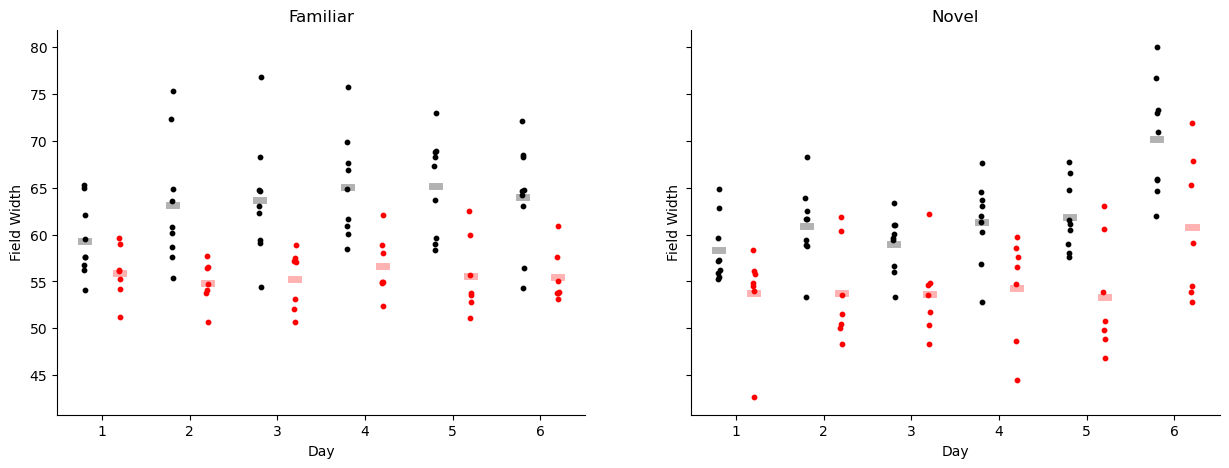

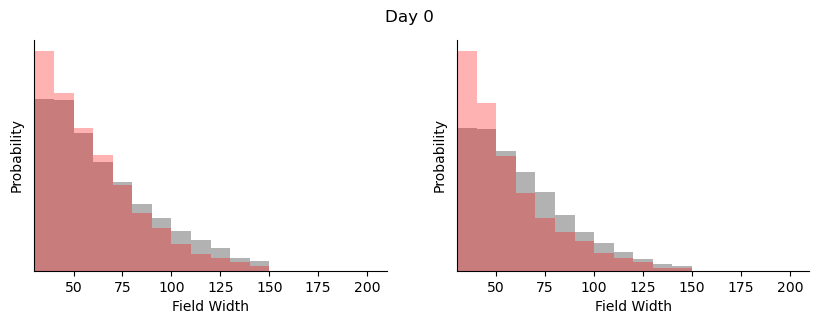

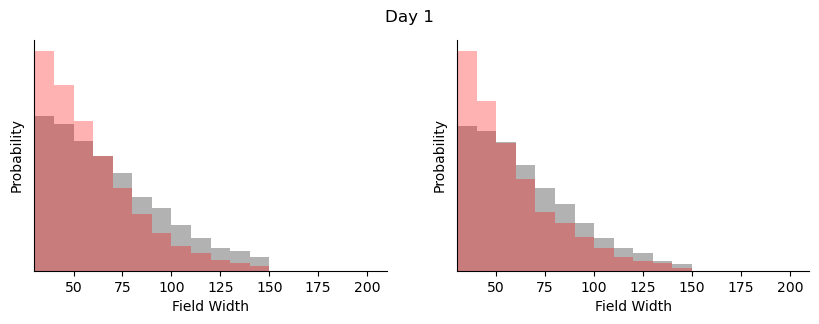

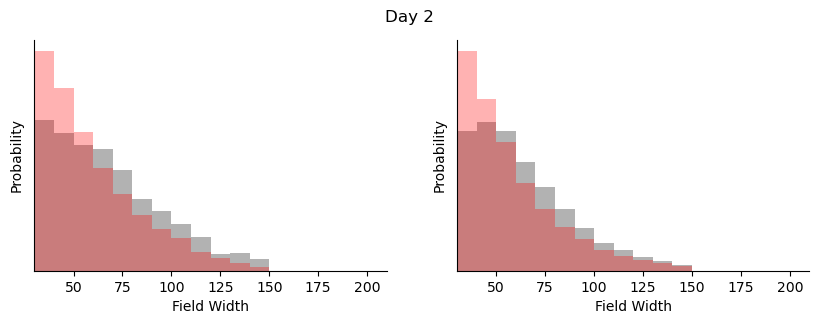

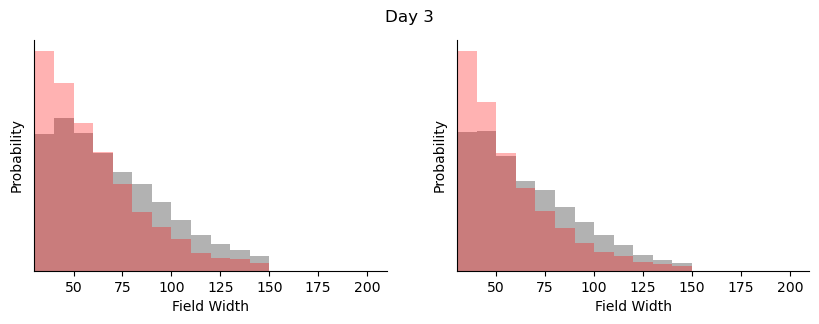

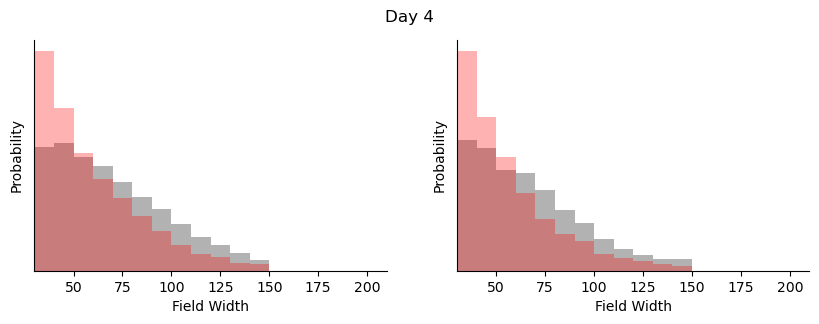

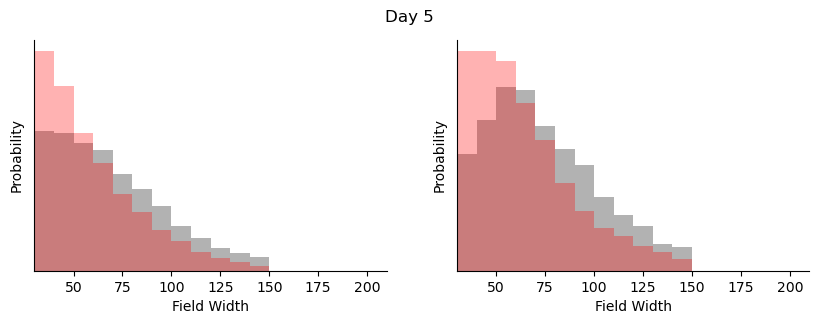

In [8]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Field Width')
    ax[a].set_xlabel('Day')
# fig.savefig(os.path.join(figdir, "field_width_across_mouse_summary.pdf"))


# single day, across mouse histograms
bin_edges = np.arange(30,210, 10)
for day in range(6):
    fig, ax = plt.subplots(1,2, figsize = [10,3])
    fig.suptitle(f'Day {day}')
    for ax_ind, ttype in enumerate(('fam', 'nov')):
        
        ctrl_width = []
        for mouse in ctrl_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            ctrl_width.append(f_info[:,2].ravel())
            # ctrl_width.append(10*field_stats[mouse][day][ttype]['field_width'].ravel())
            
        ctrl_width = np.concatenate(ctrl_width)
        
        ax[ax_ind].hist(ctrl_width, bins=bin_edges, color='black', alpha=.3, density=True)
        
        ko_width = []
        for mouse in ko_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            ko_width.append(f_info[:,2].ravel())
            # ko_width.append(10*field_stats[mouse][day][ttype]['field_width'].ravel())
            
        ko_width = np.concatenate(ko_width)
        print(ko_width)
        ax[ax_ind].hist(ko_width, bins=bin_edges, color='red', alpha=.3, density=True)
        

        ax[ax_ind].spines['top'].set_visible(False)
        ax[ax_ind].spines['right'].set_visible(False)
    
        ax[ax_ind].set_yticks([])
        ax[ax_ind].set_ylabel('Probability')
        ax[ax_ind].set_xlabel('Field Width')
        ax[ax_ind].set_xlim(30,210)
        
        # fig.savefig(os.path.join(figdir, f"day{day}_field_width_hist.pdf"))


print('Familiar ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='fam') & (df['day']<5)], dv='field_width', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[df['ttype']=='fam'], dv='field_width', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

print('Novel ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='nov') & (df['day']<5)], dv='field_width', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[df['ttype']=='nov'], dv='field_width', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)


Text(0.5, 0, 'Day')

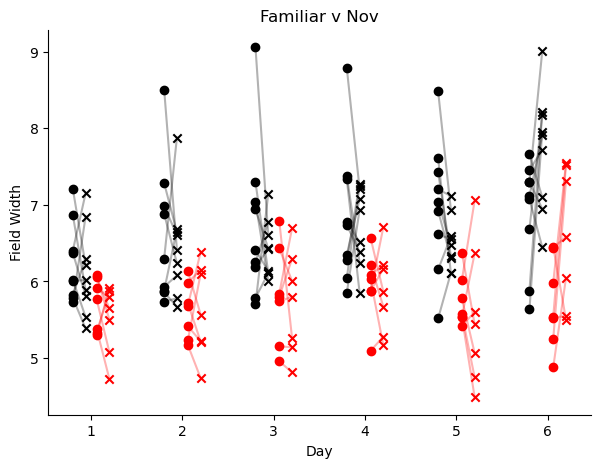

In [13]:
fig, ax = plt.subplots(figsize=[7,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ctrl_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        # ax[0].scatter(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        ax.scatter(5*day - 1,lr[0], color='black', alpha = 1, marker='o')
        ax.scatter(5*day - .3, lr[1], color='black', alpha = 1, marker='x')
        
    mask = (df['cond']=='cre') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ko_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([.3,1]), lr, color='red', alpha = .3)
        ax.scatter(5*day + .3,lr[0], color='red', alpha = 1, marker='o')
        ax.scatter(5*day + 1, lr[1], color='red', alpha = 1, marker='x')

# ax.plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)

    
ax.set_title('Familiar v Nov')

ax.set_xticks(np.arange(0,6*5,5))
ax.set_xticklabels([x for x in range(1,7)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Field Width')
ax.set_xlabel('Day')
    
# fig.savefig(os.path.join(figdir,"log_activity_rate_summary_within_group.pdf"),format='pdf')

Familiar ANOVA
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0         cond  0.491919    1   14  0.491919  24.839316  0.000200  0.639541   
1          day  0.004524    4   56  0.001131   0.328303  0.857805  0.022913   
2  Interaction  0.061940    4   56  0.015485   4.495134  0.003209  0.243044   

        eps  
0       NaN  
1  0.740781  
2       NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True -0.280320  15.000000   
1          day   -    0     2   True        True -0.246041  15.000000   
2          day   -    0     3   True        True -0.083130  15.000000   
3          day   -    0     4   True        True -0.751606  15.000000   
4          day   -    0     5   True        True -0.045954  15.000000   
5          day   -    1     2   True        True  0.120324  15.000000   
6          day   -    1     3   True        True  0.292987  15.000000   
7          day   -    1     

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

      Contrast day    A     B Paired  Parametric          T        dof  \
0          day   -    0     1   True        True   0.050790  15.000000   
1          day   -    0     2   True        True   0.582901  15.000000   
2          day   -    0     3   True        True   1.075722  15.000000   
3          day   -    0     4   True        True  -0.101892  15.000000   
4          day   -    0     5   True        True  11.718862  15.000000   
5          day   -    1     2   True        True   0.681283  15.000000   
6          day   -    1     3   True        True   1.295995  15.000000   
7          day   -    1     4   True        True  -0.140420  15.000000   
8          day   -    1     5   True        True  11.370857  15.000000   
9          day   -    2     3   True        True   1.129376  15.000000   
10         day   -    2     4   True        True  -0.614045  15.000000   
11         day   -    2     5   True        True  10.854015  15.000000   
12         day   -    3     4   True  

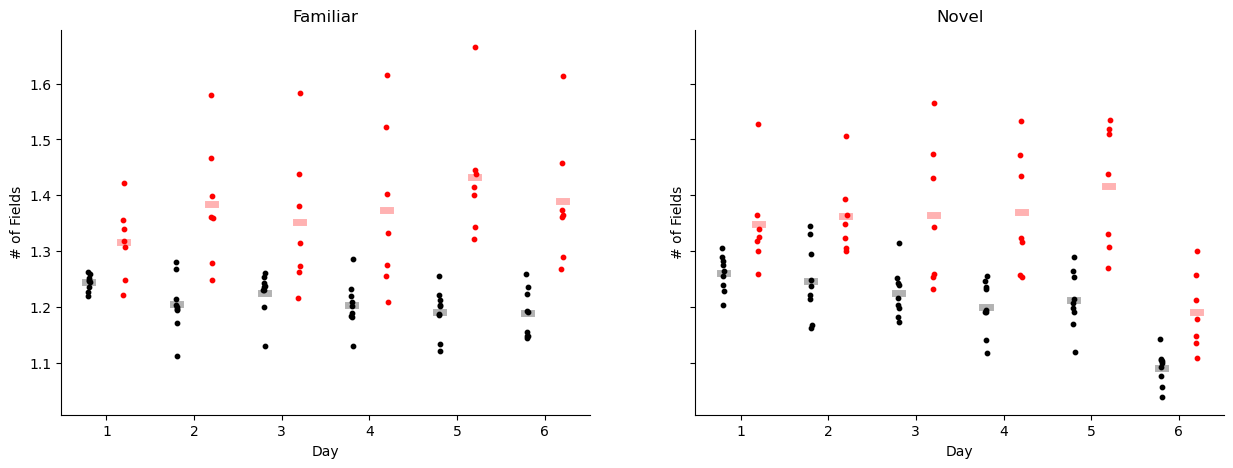

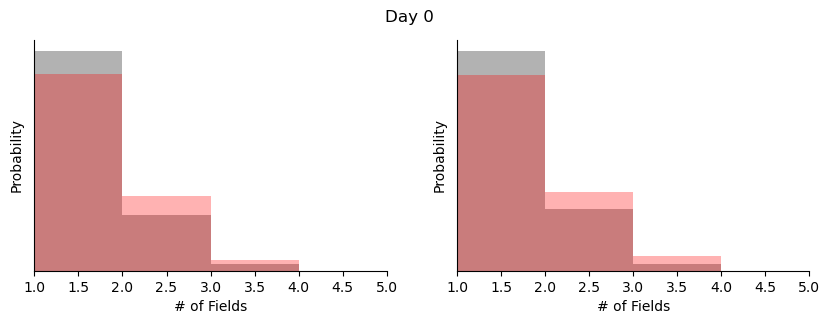

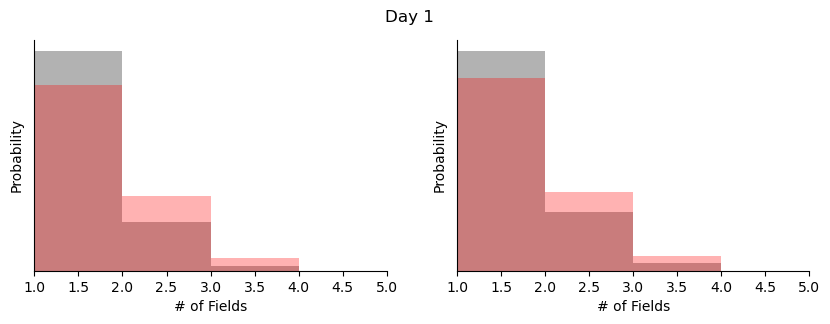

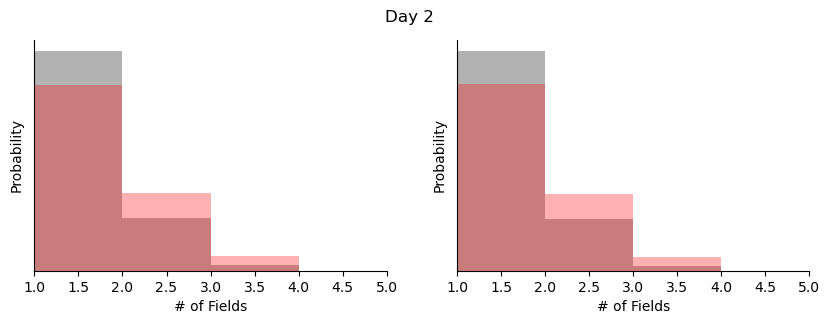

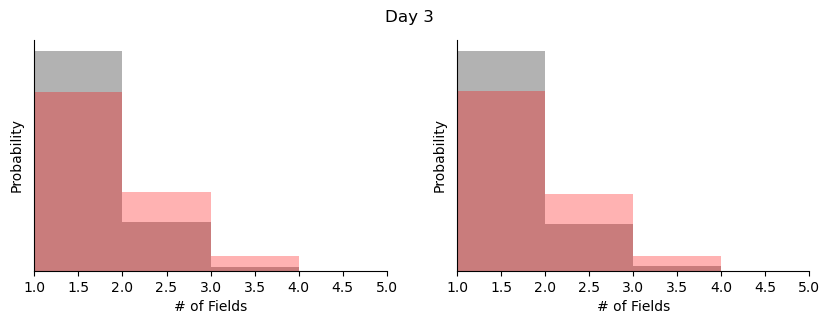

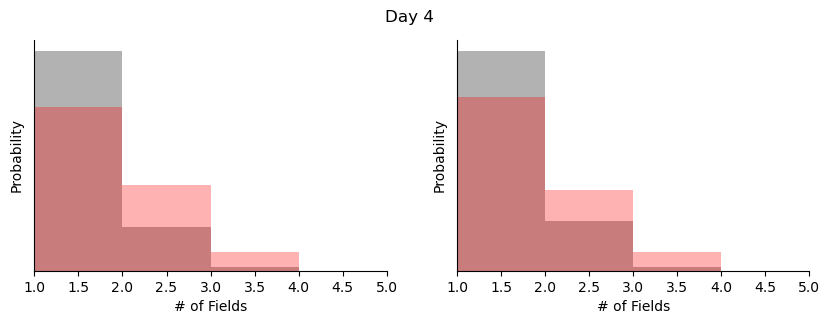

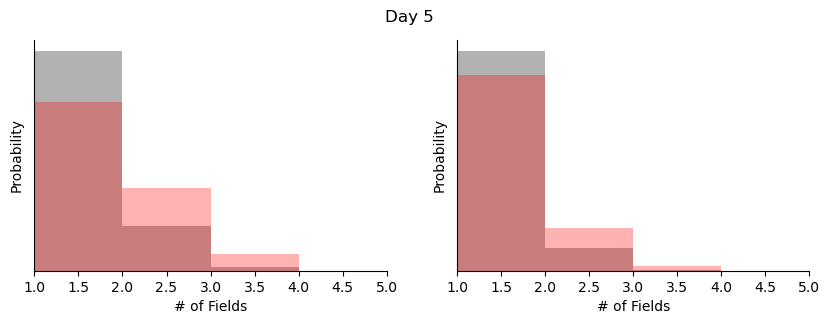

In [14]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('# of Fields')
    ax[a].set_xlabel('Day')
# fig.savefig(os.path.join(figdir, "num_fields_across_mouse_summary.pdf"))



# single day, across mouse histograms
bin_edges = np.arange(0,5, 1)
for day in range(6):
    fig, ax = plt.subplots(1,2, figsize = [10,3])
    fig.suptitle(f'Day {day}')
    for ax_ind, ttype in enumerate(('fam', 'nov')):
        
        ctrl_width = []
        for mouse in ctrl_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            cell_list = np.unique(f_info[:,0])
            
            ctrl_width.append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).ravel())
            
            
        ctrl_width = np.concatenate(ctrl_width)
        
        ax[ax_ind].hist(ctrl_width, bins=bin_edges, color='black', alpha=.3, density=True)
        
        ko_width = []
        for mouse in ko_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            cell_list = np.unique(f_info[:,0])
                
            ko_width.append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).ravel())
            
        ko_width = np.concatenate(ko_width)
        ax[ax_ind].hist(ko_width, bins=bin_edges, color='red', alpha=.3, density=True)
        

        ax[ax_ind].spines['top'].set_visible(False)
        ax[ax_ind].spines['right'].set_visible(False)
    
        ax[ax_ind].set_yticks([])
        ax[ax_ind].set_ylabel('Probability')
        ax[ax_ind].set_xlabel('# of Fields')
        ax[ax_ind].set_xlim(1,5)
        
        # fig.savefig(os.path.join(figdir, f"day{day}_num_fields_hist.pdf"))


print('Familiar ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='fam') & (df['day']<5)], dv='n_fields', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[(df['ttype']=='fam')], dv='n_fields', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

print('Novel ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='nov') & (df['day']<5)], dv='n_fields', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[(df['ttype']=='nov')], dv='n_fields', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)



Text(0.5, 0, 'Day')

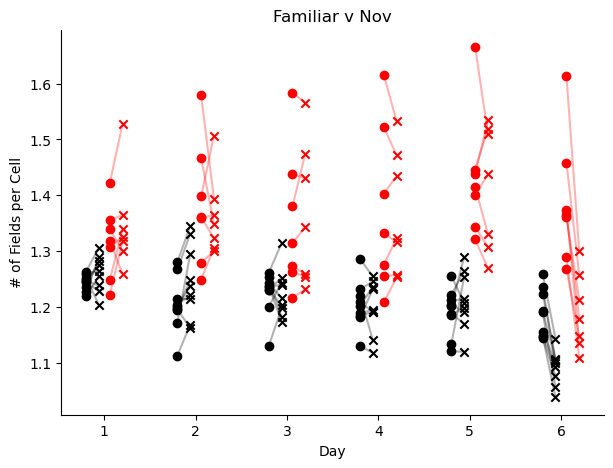

In [15]:
fig, ax = plt.subplots(figsize=[7,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ctrl_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['n_fields'].loc[_df['ttype']=='fam']._values, _df['n_fields'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        # ax[0].scatter(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        ax.scatter(5*day - 1,lr[0], color='black', alpha = 1, marker='o')
        ax.scatter(5*day - .3, lr[1], color='black', alpha = 1, marker='x')
        
    mask = (df['cond']=='cre') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ko_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['n_fields'].loc[_df['ttype']=='fam']._values, _df['n_fields'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([.3,1]), lr, color='red', alpha = .3)
        ax.scatter(5*day + .3,lr[0], color='red', alpha = 1, marker='o')
        ax.scatter(5*day + 1, lr[1], color='red', alpha = 1, marker='x')

# ax.plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)

    
ax.set_title('Familiar v Nov')

ax.set_xticks(np.arange(0,6*5,5))
ax.set_xticklabels([x for x in range(1,7)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('# of Fields per Cell')
ax.set_xlabel('Day')

/tmp/ipykernel_3875539/3248151192.py:40: RuntimeWarning: Mean of empty slice
  mu, sem = np.nanmean(ctrl_com,axis=0), sp.stats.sem(ctrl_com,axis=0, nan_policy='omit')
/tmp/ipykernel_3875539/3248151192.py:73: RuntimeWarning: Mean of empty slice
  mu, sem = np.nanmean(ko_com,axis=0), sp.stats.sem(ko_com,axis=0, nan_policy='omit')


-16.858559661214155 6.067298797426965e-63
-16.146577376181067 5.39049053046782e-58
-14.49715406963647 3.173550328510143e-47
-14.265567737901796 8.835877226813362e-46
-16.77383417622147 2.2724974191163026e-62
-8.189584085774541 2.875200612657969e-16
-19.902602150864922 6.192550315277132e-87
-16.172195847734102 2.6366353798520444e-58
-19.28936805124876 6.645832002444798e-82
-11.558273719155023 9.238016561760887e-31
-11.220356360462672 4.384765239355748e-29
-2.9624171313489702 0.0030616742818091653


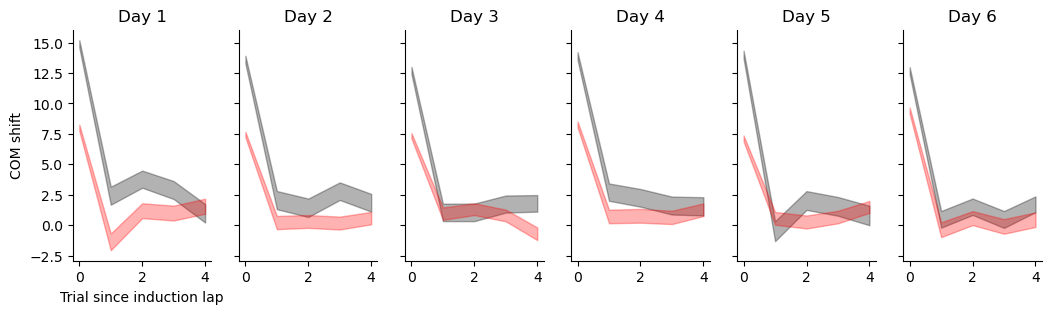

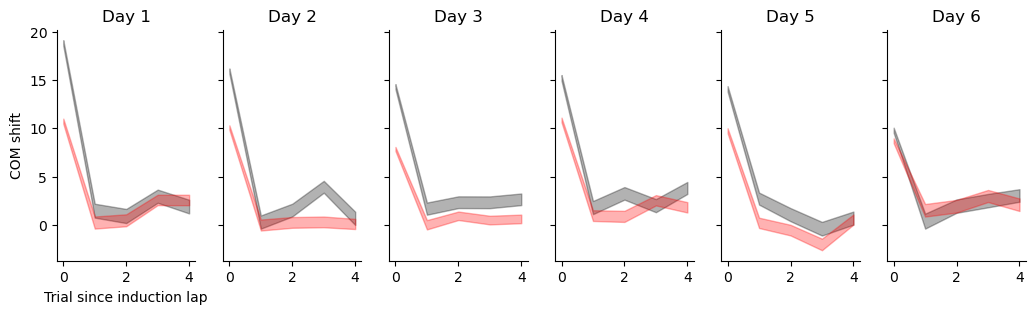

In [6]:

max_trial=140 #5
plot_max = 5
# ttype = 'nov'
df = {'mouse': [], 'cond':[], 'day':[], 'shift':[], 'nov':[]}
for ttype in ('fam', 'nov'):
    fig, ax = plt.subplots(1,6, sharey=True, figsize=[12.5,3])
    for day in range(6):
        # com = []
        # ctrl_com = np.nan*np.zeros((len(ctrl_mice),max_trial))
        ctrl_com = []
        for m, mouse in enumerate(ctrl_mice):
            
            
            field_info = np.array(field_stats[mouse][day][ttype]['field_info'])
            _com = field_stats[mouse][day][ttype]['com']
            
            mask = field_info[:,1]>0
            
            _com = (_com[:, mask] - np.nanmean(_com[1:, mask], axis=0,keepdims=True))
            
            for c in range(_com.shape[1]):
                _ctrl_com = np.nan*np.zeros((max_trial,))
                _ctrl_com[:_com.shape[0]] = 10*_com[:,c]
                ctrl_com.append(_ctrl_com)
            
            
            
            # ctrl_com[m,:_com.shape[0]] = 10*np.nanmean(_com, axis=-1)
            

            df['mouse'].append(mouse)
            df['cond'].append('ctrl')
            df['day'].append(day)
            
            df['shift'].append(10*np.nanmean(_com[0,:]))
            df['nov'].append(ttype)

            
        ctrl_com = np.array(ctrl_com)
        mu, sem = np.nanmean(ctrl_com,axis=0), sp.stats.sem(ctrl_com,axis=0, nan_policy='omit')           
        ax[day].fill_between(np.arange(plot_max), mu[:plot_max]+sem[:plot_max], mu[:plot_max]-sem[:plot_max], color='black', alpha=.3) 

        # com = []
        # ko_com = np.nan*np.zeros((len(ko_mice), max_trial))
        ko_com=[]
        for m, mouse in enumerate(ko_mice):
            _com = field_stats[mouse][day][ttype]['com']
            
            field_info = np.array(field_stats[mouse][day][ttype]['field_info']) 
            mask = field_info[:,1]>0
            
            _com = (_com[:, mask] - np.nanmean(_com[1:,:][:,mask], axis=0,keepdims=True))
            
            for c in range(_com.shape[1]):
                _ko_com = np.nan*np.zeros((max_trial,))
                _ko_com[:_com.shape[0]] = 10*_com[:,c]
                ko_com.append(_ko_com)
            
            # ko_com[m,:_com.shape[0]] = 10*np.nanmean(_com, axis=-1)

            df['mouse'].append(mouse)
            df['cond'].append('cre')
            df['day'].append(day)
            
            df['shift'].append(10*np.nanmean(_com[0,:]))
            df['nov'].append(ttype)


            


        ko_com = np.array(ko_com)
        mu, sem = np.nanmean(ko_com,axis=0), sp.stats.sem(ko_com,axis=0, nan_policy='omit')           
        ax[day].fill_between(np.arange(plot_max), mu[:plot_max]+sem[:plot_max], mu[:plot_max]-sem[:plot_max], color='red', alpha=.3) 


        ax[day].spines['top'].set_visible(False)
        ax[day].spines['right'].set_visible(False)
        ax[day].set_title(f'Day {day+1}')


        t, p = sp.stats.ttest_ind(ko_com[:, 0], ctrl_com[:,0])
        print(t,p)

        ax[0].set_ylabel('COM shift')
        ax[0].set_xlabel('Trial since induction lap')
        

# fig.savefig(os.path.join(figdir, f"single_field_COM_shift_maxtrial_{plot_max}_ttype_{ttype}.pdf"))
df = pd.DataFrame(df)

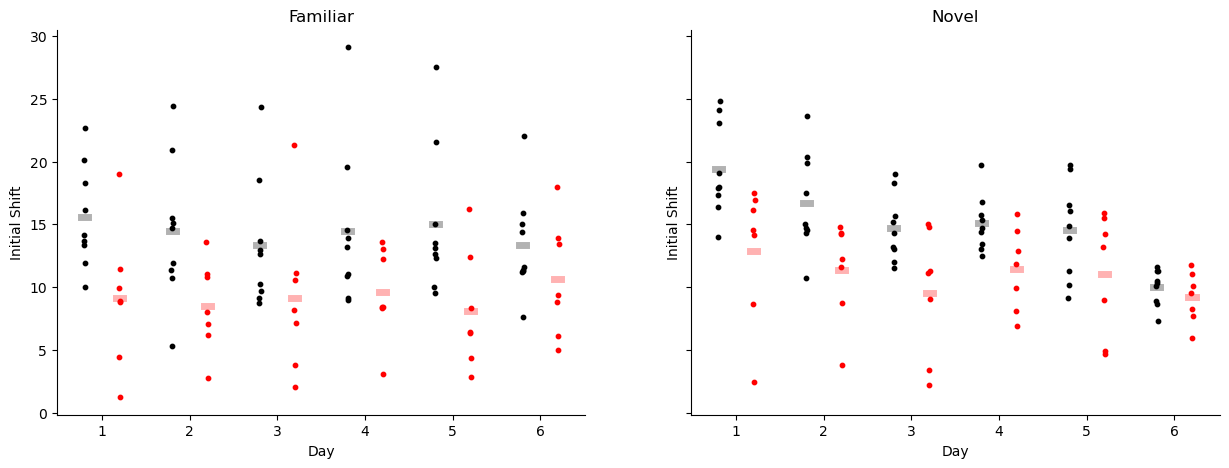

In [7]:
# summary plot 
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

lw = 5
s = 10
key = 'shift'
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['nov']=='fam')
    lr = df[key].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['nov']=='nov')
    lr = df[key].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['nov']=='fam')
    lr = df[key].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day)& (df['nov']=='nov')
    lr = df[key].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Initial Shift')
    ax[a].set_xlabel('Day')

# fig.savefig(os.path.join(figdir, 'famnov_init_shift_summary.pdf'))



In [8]:
ddf = df[(df['day']<5) & (df['nov']=='nov') ]
aov = mixed_anova(data=ddf, dv='shift', between='cond', within='day', subject='mouse')
print(aov)
stats = pg.pairwise_tests(data=ddf, dv='shift', between='cond', within='day', subject='mouse', padjust='holm')
print(stats)

        Source          SS  DF1  DF2          MS         F     p-unc  \
0         cond  460.457313    1   14  460.457313  9.243569  0.008817   
1          day  166.177051    4   56   41.544263  6.092632  0.000384   
2  Interaction   24.632045    4   56    6.158011  0.903097  0.468470   

        np2       eps  
0  0.397683       NaN  
1  0.303227  0.774005  
2  0.060598       NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True  3.250174  15.000000   
1          day   -    0     2   True        True  5.535107  15.000000   
2          day   -    0     3   True        True  2.897603  15.000000   
3          day   -    0     4   True        True  3.307935  15.000000   
4          day   -    1     2   True        True  2.363520  15.000000   
5          day   -    1     3   True        True  0.903393  15.000000   
6          day   -    1     4   True        True  1.793182  15.000000   
7          day   -    2     3  

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

In [9]:
np.array(field_info)

array([[ 38.        ,   0.        ,   4.        ,   1.        ,
         44.59089298,  46.72182156],
       [ 91.        ,   0.        ,  14.        ,   0.        ,
         16.28808699,  50.10071416],
       [309.        ,   0.        ,   9.        ,   1.        ,
         49.78961198,  49.50988343],
       ...,
       [403.        ,  25.        ,   3.        ,   0.        ,
          8.16383418,  10.56960949],
       [715.        ,  25.        ,   3.        ,   0.        ,
          8.16383418,  10.56960949],
       [979.        ,  25.        ,   3.        ,   0.        ,
          8.16383418,  10.56960949]])

(14, 14)
(14, 1)


/tmp/ipykernel_3875539/3786856742.py:69: RuntimeWarning: invalid value encountered in divide
  COM = (H_ctrl*shift_bins[np.newaxis,1:]).sum(axis=1,keepdims=True)/(H_ctrl.sum(axis=1)[:, np.newaxis])
/tmp/ipykernel_3875539/3786856742.py:70: RuntimeWarning: invalid value encountered in divide
  COM = COM - (H_ko*shift_bins[np.newaxis,1:]).sum(axis=1,keepdims=True)/(H_ko.sum(axis=1)[:, np.newaxis])


(14, 14)
(14, 1)
(14, 14)
(14, 1)
(14, 14)
(14, 1)
(14, 14)
(14, 1)
(14, 14)
(14, 1)


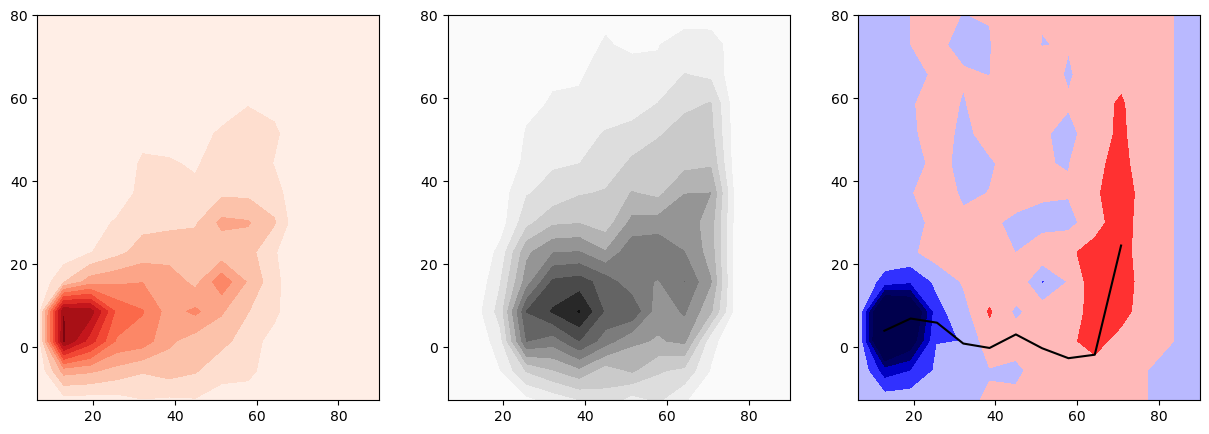

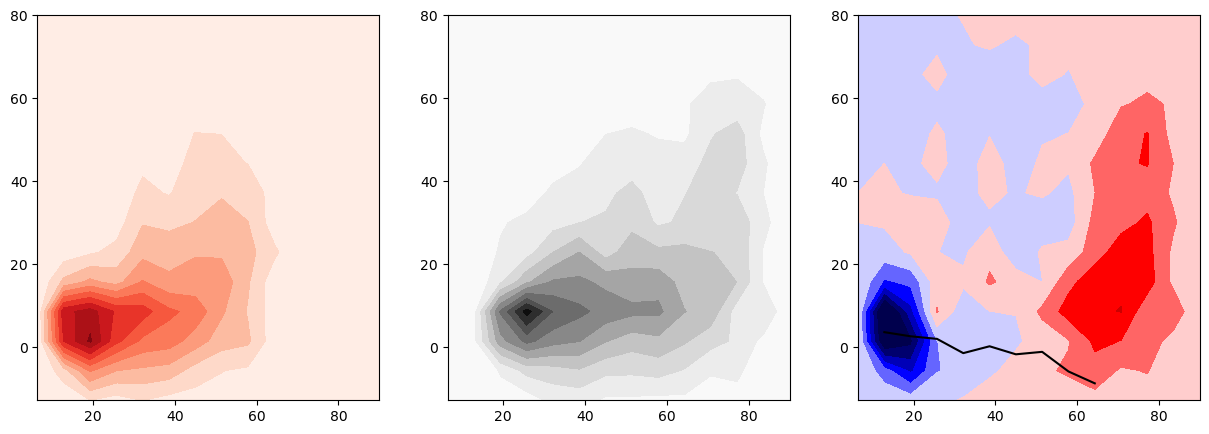

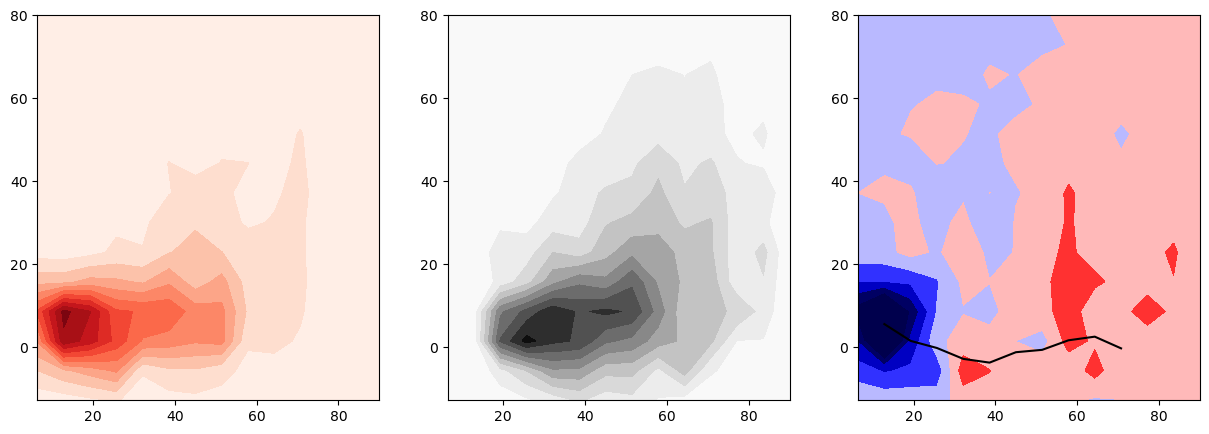

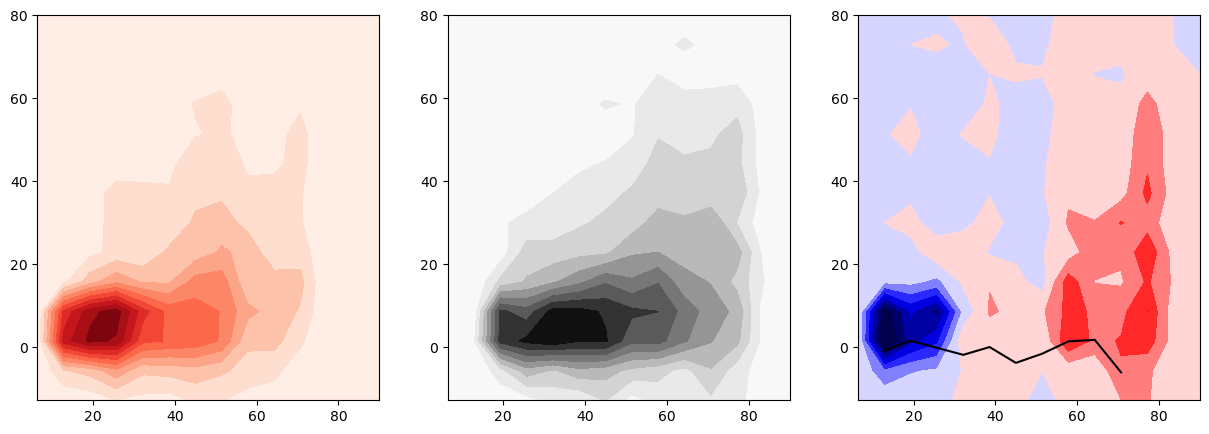

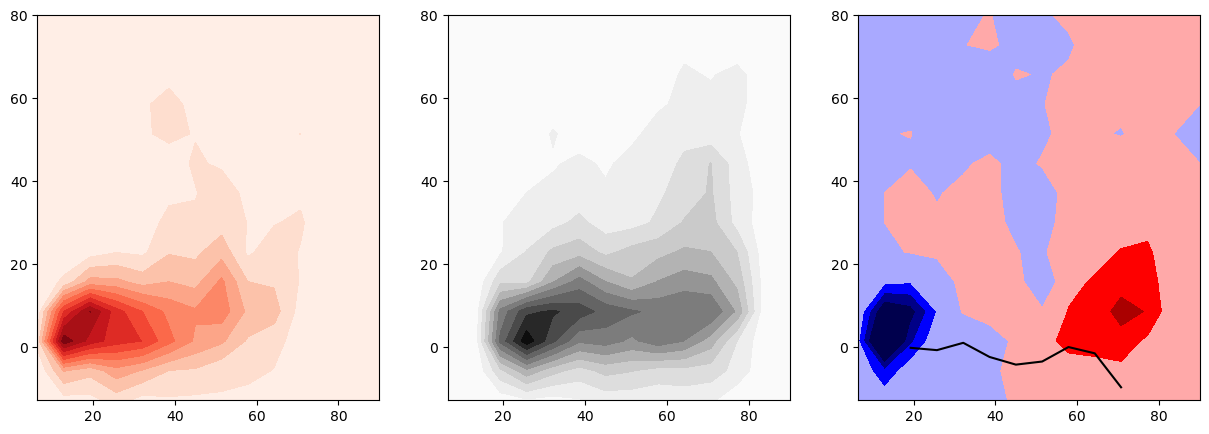

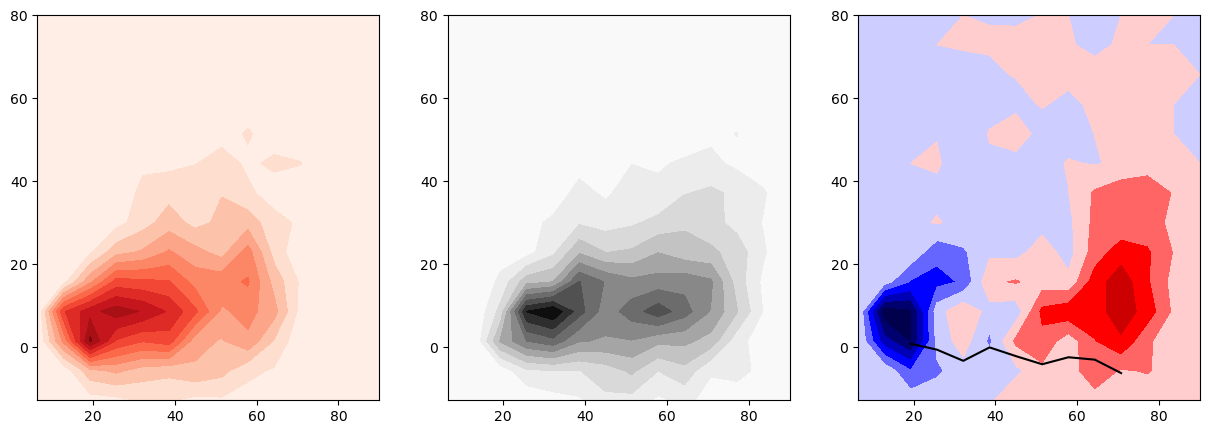

In [10]:

day = 0
ttype= 'nov'

for day in range(6):
    shift, speed = [], []
    for mouse in ko_mice:

        field_info = np.array(field_stats[mouse][day][ttype]['field_info'])
        mask = field_info[:,1]>0
            
        com = field_stats[mouse][day][ttype]['com'][:, mask]
        com = com - np.nanmean(com[1:,:],axis=0, keepdims=True)
        # shift.append(field_stats[mouse][day][ttype]['fwhm'])
        shift.append(10*com[0,:])
        # shift.append(10*field_stats[mouse][day][ttype]['std'])
        speed.append(np.array(field_info)[mask,-1])

    shift = np.concatenate(shift)
    speed = np.concatenate(speed)

    # print(shift.shape)

    mask = ~np.isnan(shift) & (shift>-50) & (speed>1) & (shift<200) & (speed<80)
    fig, ax = plt.subplots(1,3,figsize=[15,5]) #,sharey=True, sharex=True, )
    speed_bins = np.linspace(0, 90, num=15)
    shift_bins = np.linspace(-20,80, num=15)
    # shift_bins = np.linspace(0,150, num=15)
    X,Y = np.meshgrid(speed_bins[1:], shift_bins[1:])
    

    H, _, _ = np.histogram2d(speed[mask], shift[mask], bins = [speed_bins,shift_bins], density=True)
    H_ko =np.copy(H)
    H_ko = H_ko/(H_ko.sum(axis=1, keepdims=True)+1E-3)
    print(H.shape)
    
    ax[0].contourf(X, Y, H_ko.T, 10, cmap='Reds')
    

    shift, speed = [], []
    for mouse in ctrl_mice:


        field_info = np.array(field_stats[mouse][day][ttype]['field_info'])
        mask = field_info[:,1]>0 
            
        com = field_stats[mouse][day][ttype]['com'][:, mask]
        # com = field_stats[mouse][day][ttype]['com']
        com = com - np.nanmean(com[1:,:],axis=0, keepdims=True)
        # shift.append(field_stats[mouse][day][ttype]['fwhm'])
        shift.append(10*com[0,:])
        # shift.append(10*field_stats[mouse][day][ttype]['std'])
        speed.append(np.array(field_info)[mask,-1])

    shift = np.concatenate(shift)
    speed = np.concatenate(speed)

    # print(shift.shape)

    mask = ~np.isnan(shift) & (shift>-50) & (speed>1) & (shift<200) & (speed<80)
    H, _, _ = np.histogram2d(speed[mask], shift[mask], bins = [speed_bins,shift_bins], density=True)
    H_ctrl = np.copy(H)
    H_ctrl = H_ctrl/(H_ctrl.sum(axis=1, keepdims=True)+1E-3)
    
    ax[1].contourf(X, Y, H_ctrl.T, 10, cmap='Greys')
    res = sp.stats.pearsonr(speed[mask],shift[mask])
    
    ax[2].contourf(X, Y, (H_ctrl-H_ko).T, 10, cmap='seismic', vmin=-.15, vmax=.15)
    diff = H_ctrl-H_ko
    COM = (H_ctrl*shift_bins[np.newaxis,1:]).sum(axis=1,keepdims=True)/(H_ctrl.sum(axis=1)[:, np.newaxis])
    COM = COM - (H_ko*shift_bins[np.newaxis,1:]).sum(axis=1,keepdims=True)/(H_ko.sum(axis=1)[:, np.newaxis])
    print(COM.shape)
    ax[2].plot(speed_bins[1:], COM, color='black')
    ax[2].plot(speed_bins[1:],0*speed_bins[1:], color='blue', zorder=-1)

# print(res)

In [25]:
df = {'mouse':[], 'cond': [], 'ttype': [], 'day':[], 'shift': [], 'width': [], 'fwhm': [], 'speed': []}

for cond, mice in zip(('ctrl', 'cre'), (ctrl_mice, ko_mice)):
    
    for mouse in mice:
        
        for day in range(6):
            for ttype in ('nov','fam'):
                field_info = np.array(field_stats[mouse][day][ttype]['field_info'])
                mask = field_info[:,1]>0
                field_info = field_info[mask,:]
            
                # com = field_stats[mouse][day][ttype]['com'][:, mask]
                fwhm = field_stats[mouse][day][ttype]['fwhm'][mask]
                
                com = field_stats[mouse][day][ttype]['com'][:, mask]
                com = com - np.nanmean(com[1:,:],axis=0, keepdims=True)
    
    
                # for f, field in enumerate(field_info):
                for f in range(field_info.shape[0]):
                    # cell, left edge, right edge, formation lap, formation lap speed
                    df['mouse'].append(mouse)
                    df['cond'].append(cond)
                    df['ttype'].append(ttype)
                    df['day'].append(day)
                    df['shift'].append(10*com[0, f])
                    df['width'].append(10*field_info[f, 2])
                    df['fwhm'].append(10*fwhm[f])
                    df['speed'].append(field_info[f,4])
                    
                    
df = pd.DataFrame(df)
            # print(mouse, day, len(field_info))
            # com = field_stats[mouse][day][ttype]['com']
            # com = com - com[:1,:]
            # shift.append(com[1,:])
            # speed.append(np.array(field_info)[:,-1])


In [26]:
_df = df.loc[(df['cond']=='ctrl') * (df['ttype']=='nov') * (df['day']==0)]
r, p = sp.stats.pearsonr(_df['shift'], _df['speed'])
print(r,p)

0.11973651893461819 9.660783655724763e-27


In [27]:
import statsmodels.formula.api as smf

ddf = df[(df['ttype']=='nov') * (df['day']<5) * (df['width']<100)]# * (df['speed']<60) * (df['speed']>10)]
# model = smf.ols('shift ~ C(cond) + speed*C(day)', ddf).fit()
model = smf.mixedlm('shift ~  C(cond) + speed*C(day)', ddf, groups = 'mouse').fit()
model = smf.mixedlm('shift ~  C(cond) + speed*C(day)', ddf, groups = 'mouse').fit(start_params=model.params)
# results = model.fit()

print(model.summary())
print(model.wald_test_terms())

# ddf = df[(df['ttype']=='nov') * (df['day']<5) * (df['width']<100)]# * (df['speed']<60) * (df['speed']>10)]
# model = smf.mixedlm('width ~ speed*C(cond) + C(day)', ddf, groups = 'mouse').fit()
# model = smf.mixedlm('width ~ speed*C(cond) + C(day)', ddf, groups = 'mouse').fit(start_params=model.params)
# # results = model.fit()

# print(model.summary())
# print(model.wald_test_terms())

# ddf = df[(df['day']==0) * (df['width']<300) * (df['cond']=='ctrl') * (df['speed']<70)* (df['speed']>10)]
# model = smf.mixedlm('width ~ speed*C(ttype)  ', ddf, groups = 'mouse').fit()
# model = smf.mixedlm('width ~ speed*C(ttype) ', ddf, groups = 'mouse').fit(start_params=model.params)
# # results = model.fit()

# print(model.summary())
# print(model.wald_test_terms())

# ddf = df[(df['day']==0) * (df['width']<300) * (df['cond']=='cre') * (df['speed']<70) * (df['speed']>10)]
# model = smf.mixedlm('width ~ speed*C(ttype)  ', ddf, groups = 'mouse').fit()
# model = smf.mixedlm('width ~ speed*C(ttype) ', ddf, groups = 'mouse').fit(start_params=model.params)
# # results = model.fit()

# print(model.summary())
# print(model.wald_test_terms())

# ddf = df[(df['day']==0) * (df['ttype']=='nov') * (df['speed']<70)* (df['speed']>10)]
# model = smf.mixedlm('width ~ speed*C(cond)  ', ddf, groups = 'mouse').fit()
# model = smf.mixedlm('width ~ speed*C(cond) ', ddf, groups = 'mouse').fit(start_params=model.params)
# # results = model.fit()

# print(model.summary())
# print(model.wald_test_terms())


# # ddf = df[(df['cond']=='ctrl') * (df['day']<5) * (df['width']<300)]# * (df['speed']<60) * (df['speed']>10)]
# ddf = df[(df['day']==0) * (df['width']<300) * (df['speed']<70) * (df['speed']>10)]
# model = smf.mixedlm('width ~ speed*C(ttype)*C(cond)  ', ddf, groups = 'mouse').fit()
# model = smf.mixedlm('width ~ speed*C(ttype)*C(cond) ', ddf, groups = 'mouse').fit(start_params=model.params)
# # results = model.fit()

# print(model.summary())
# print(model.wald_test_terms())


# ddf = df[(df['cond']=='ctrl') * (df['day']==0) * (df['ttype']=='nov')]
# n_fam = ddf.shape[0]
# r,p = sp.stats.pearsonr(ddf['width'],ddf['speed'])
# r_fam = np.arctanh(r)
# print(r,p)

# ddf = df[(df['cond']=='cre') * (df['day']==0) * (df['ttype']=='nov')]
# n_nov = ddf.shape[0]
# r,p = sp.stats.pearsonr(ddf['width'],ddf['speed'])
# r_nov = np.arctanh(r)
# print(r,p)

# z = (r_nov-r_fam)/np.sqrt(1/(n_fam-3) + 1/(n_nov-3))
# print(sp.stats.norm.sf(z))

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: shift       
No. Observations:   64301   Method:             REML        
No. Groups:         16      Scale:              465.3705    
Min. group size:    1579    Log-Likelihood:     -288776.0685
Max. group size:    9194    Converged:          Yes         
Mean group size:    4018.8                                  
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          5.027    0.895  5.619 0.000  3.273  6.780
C(cond)[T.ctrl]    3.010    1.052  2.861 0.004  0.948  5.071
C(day)[T.1]       -2.205    0.598 -3.690 0.000 -3.376 -1.034
C(day)[T.2]       -3.850    0.585 -6.585 0.000 -4.997 -2.704
C(day)[T.3]       -0.146    0.595 -0.245 0.806 -1.312  1.020
C(day)[T.4]       -0.813    0.584 -1.393 0.164 -1.957  0.331
speed              0.303    0.012 25

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [28]:
import statsmodels.formula.api as smf

for day in range(6):
    ddf = df[(df['ttype']=='nov') * (df['day']==day) * (df['fwhm']<300) * (df['speed']<80) * (df['speed']>0)]
    # model = smf.ols('shift ~ speed + C(cond)', ddf).fit()
    model = smf.mixedlm('shift ~ speed + C(cond)', ddf, groups = 'mouse').fit()
    model = smf.mixedlm('shift ~ speed + C(cond)', ddf, groups = 'mouse').fit(start_params=model.params)
    # # results = model.fit()
    print(f'day {day}')
    print(model.summary())
    print(model.wald_test_terms(scalar=True))

day 0
          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: shift      
No. Observations:  13932   Method:             REML       
No. Groups:        16      Scale:              536.1712   
Min. group size:   257     Log-Likelihood:     -63568.8118
Max. group size:   1975    Converged:          Yes        
Mean group size:   870.8                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        7.456    1.397  5.338 0.000  4.719 10.194
C(cond)[T.ctrl]  4.494    1.767  2.544 0.011  1.031  7.956
speed            0.183    0.015 12.086 0.000  0.153  0.213
mouse Var       11.422    0.197                           

                 chi2        P>chi2  df constraint
Intercept   28.496637  9.386139e-08              1
C(cond)      6.470848  1.096582e-02              1
speed      146.075224  1.

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood o

day 1
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shift      
No. Observations: 13956   Method:             REML       
No. Groups:       16      Scale:              434.5858   
Min. group size:  448     Log-Likelihood:     -62209.4103
Max. group size:  1830    Converged:          Yes        
Mean group size:  872.2                                  
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       3.726    1.012  3.682 0.000  1.743  5.709
C(cond)[T.ctrl] 2.667    1.239  2.152 0.031  0.238  5.095
speed           0.244    0.013 18.326 0.000  0.218  0.271
mouse Var       5.412    0.109                           

                 chi2        P>chi2  df constraint
Intercept   13.559087  2.311695e-04              1
C(cond)      4.631295  3.139385e-02              1
speed      335.859771  5.088090e-75   

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


day 3
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shift      
No. Observations: 13838   Method:             REML       
No. Groups:       16      Scale:              477.8268   
Min. group size:  353     Log-Likelihood:     -62337.2169
Max. group size:  2211    Converged:          Yes        
Mean group size:  864.9                                  
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       4.807    0.911  5.276 0.000  3.021  6.592
C(cond)[T.ctrl] 1.312    1.097  1.196 0.232 -0.838  3.462
speed           0.208    0.013 16.304 0.000  0.183  0.233
mouse Var       4.033    0.082                           

                 chi2        P>chi2  df constraint
Intercept   27.840213  1.317589e-07              1
C(cond)      1.429893  2.317819e-01              1
speed      265.818278  9.253869e-60   

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


day 4
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shift      
No. Observations: 13075   Method:             REML       
No. Groups:       16      Scale:              466.6687   
Min. group size:  232     Log-Likelihood:     -58751.1344
Max. group size:  1773    Converged:          Yes        
Mean group size:  817.2                                  
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       5.506    1.203  4.576 0.000  3.148  7.864
C(cond)[T.ctrl] 0.998    1.534  0.651 0.515 -2.009  4.006
speed           0.173    0.012 14.836 0.000  0.150  0.195
mouse Var       8.502    0.160                           

                 chi2        P>chi2  df constraint
Intercept   20.943375  4.730610e-06              1
C(cond)      0.423416  5.152372e-01              1
speed      220.114706  8.538142e-50   

In [29]:
day = 0
ddf = df[(df['ttype']=='nov') * (df['day']==day) ]
# ddf = df[(df['cond']=='ctrl') * (df['day']==day) ]
# model = smf.ols('shift ~ speed + C(cond)', ddf, groups = 'mouse').fit()
model = smf.mixedlm('shift ~ speed + C(cond)', ddf, groups = 'mouse').fit()
model = smf.mixedlm('shift ~ speed + C(cond)', ddf, groups = 'mouse').fit(start_params=model.params)
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:             MixedLM Dependent Variable: shift      
No. Observations:  13949   Method:             REML       
No. Groups:        16      Scale:              536.8000   
Min. group size:   257     Log-Likelihood:     -63654.5356
Max. group size:   1975    Converged:          Yes        
Mean group size:   871.8                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        7.366    1.396  5.276 0.000  4.629 10.102
C(cond)[T.ctrl]  4.485    1.767  2.539 0.011  1.023  7.948
speed            0.186    0.015 12.352 0.000  0.157  0.216
mouse Var       11.425    0.197                           
==========================================================

"""

In [2]:
7.366+4.485

11.850999999999999

In [30]:
model.params.keys()

Index(['Intercept', 'C(cond)[T.ctrl]', 'speed', 'mouse Var'], dtype='object')

(14, 14)
PearsonRResult(statistic=0.2932037817501693, pvalue=2.2399496205574692e-119)
PearsonRResult(statistic=0.11593578207232239, pvalue=4.288589439594945e-25)


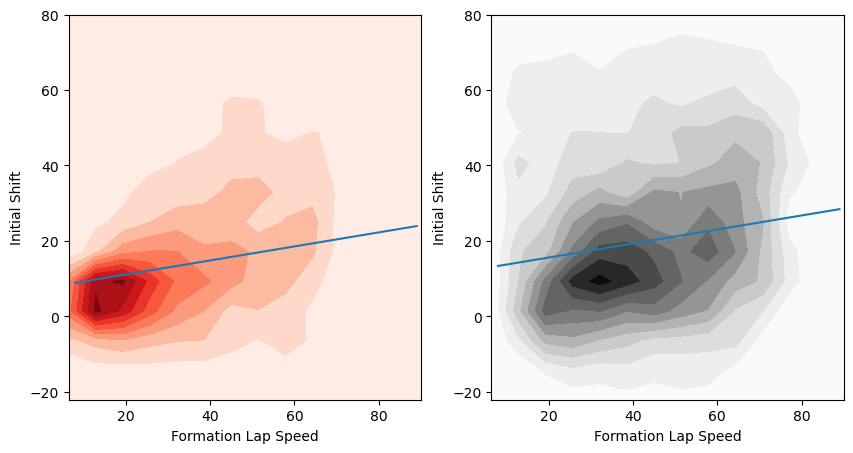

In [31]:
ttype= 'nov'
day = 0


shift, speed, ledge = [], [], []
for mouse in ko_mice:

    field_info = np.array(field_stats[mouse][day][ttype]['field_info'])
    ledge.append(field_info[:,1])
    
            
    com = field_stats[mouse][day][ttype]['com']
    com = com - np.nanmean(com[1:,:],axis=0, keepdims=True)
    
    shift.append(10*com[0,:])
    # shift.append(10*field_info[:,2])
    # shift.append(10*field_stats[mouse][day][ttype]['fwhm'])
    # shift.append(10*np.array(field_stats[mouse][day][ttype]['std']))
    speed.append(np.array(field_info)[:,-2])

shift = np.concatenate(shift)
speed = np.concatenate(speed)
ledge = np.concatenate(ledge)

# print(shift.shape)

mask = ~np.isnan(shift) & (shift>-50) & (speed>0) & (shift<200) & (speed<80) & (ledge>0)
fig, ax = plt.subplots(1,2,figsize=[10,5]) #,sharey=True, sharex=True, )
speed_bins = np.linspace(0, 90, num=15)
shift_bins = np.linspace(-30,80, num=15)
# shift_bins = np.linspace(0,110, num=10)
X,Y = np.meshgrid(speed_bins[1:], shift_bins[1:])
# ax[0].scatter(speed[mask], shift[mask], color ='red', s=2, alpha=.3)
# ax[0].plot(speed_bins, 0*speed_bins, color='blue')

H, _, _ = np.histogram2d(speed[mask], shift[mask], bins = [speed_bins,shift_bins], density=True)
H_ko =np.copy(H)
H_ko = H_ko/(H_ko.sum(axis=1, keepdims=True)+1E-3)
print(H.shape)
# ax[0].imshow((H/(H.sum(axis=1,keepdims=True)+1E-3)).T, vmin=0, vmax=.2, cmap='Reds')
ax[0].contourf(X, Y, H_ko.T, 10, cmap='Reds')
# ax[0].hist2d(speed[mask], shift[mask], bins=[speed_bins, shift_bins], cmap='PuRd', density=True, vmax=.01)
res = sp.stats.pearsonr(speed[mask],shift[mask])
print(res)

shift, speed, ledge = [], [], []
for mouse in ctrl_mice:


    field_info = np.array(field_stats[mouse][day][ttype]['field_info'])
    ledge.append(field_info[:,1])
    com = field_stats[mouse][day][ttype]['com']
    com = com - np.nanmean(com[1:,:],axis=0, keepdims=True)
    
    # shift.append(10*field_info[:,2])
    # shift.append(10*field_stats[mouse][day][ttype]['fwhm'])
    # shift.append(10*np.array(field_stats[mouse][day][ttype]['std']))
    shift.append(10*com[0,:])
    speed.append(np.array(field_info)[:,-2])

shift = np.concatenate(shift)
speed = np.concatenate(speed)
ledge = np.concatenate(ledge)



mask = ~np.isnan(shift) & (shift>-50) & (speed>0) & (shift<200) & (speed<80) & (ledge>0)
H, _, _ = np.histogram2d(speed[mask], shift[mask], bins = [speed_bins,shift_bins], density=True)
H_ctrl = np.copy(H)
H_ctrl = H_ctrl/(H_ctrl.sum(axis=1, keepdims=True)+1E-3)

ax[1].contourf(X, Y, H_ctrl.T, 10, cmap='Greys')

res = sp.stats.pearsonr(speed[mask],shift[mask])
print(res)

trials = np.arange(8,90)
y_cre = model.params['Intercept'] + model.params['speed']*trials
y_ctrl = model.params['Intercept'] + model.params['C(cond)[T.ctrl]'] + model.params['speed']*trials 
# y_ctrl = model.params['Intercept'] + model.params['C(cond)[T.ctrl]'] + (model.params['speed']+model.params['speed:C(cond)[T.ctrl]'])*trials 
ax[0].plot(trials, y_cre)
# ax[0].plot(trials, y_ctrl)

ax[0].set_xlabel('Formation Lap Speed')
ax[0].set_ylabel('Initial Shift')

# ax[1].plot(trials, y_cre, color='red')
ax[1].plot(trials, y_ctrl)

ax[1].set_xlabel('Formation Lap Speed')
ax[1].set_ylabel('Initial Shift')

fig.savefig(os.path.join(figdir, f"shift_vs_speed_day{day}.pdf"))


             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   width      
No. Observations:    10502     Method:               REML       
No. Groups:          16        Scale:                623.3550   
Min. group size:     226       Log-Likelihood:       -48711.7519
Max. group size:     1422      Converged:            Yes        
Mean group size:     656.4                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             50.082    1.570 31.894 0.000 47.005 53.160
C(cond)[T.ctrl]        1.248    2.133  0.585 0.559 -2.933  5.428
speed                  0.185    0.035  5.246 0.000  0.116  0.255
speed:C(cond)[T.ctrl]  0.025    0.044  0.569 0.569 -0.062  0.112
mouse Var              9.122    0.154                           

(9, 7)
cre r: 0.12072340005732815, p: 

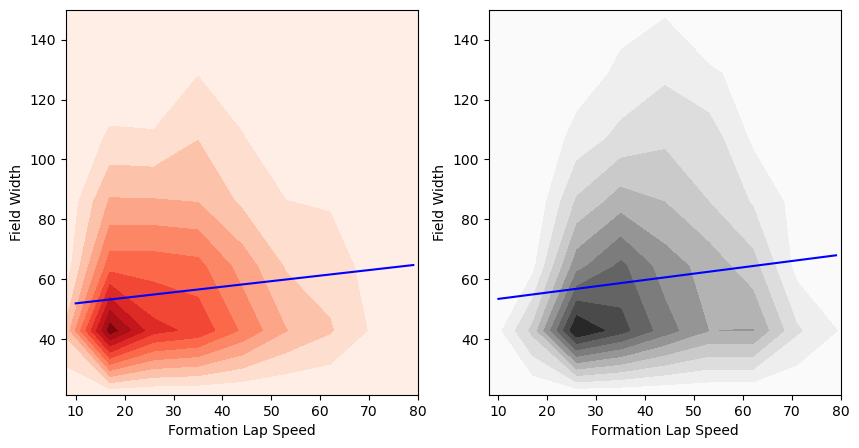

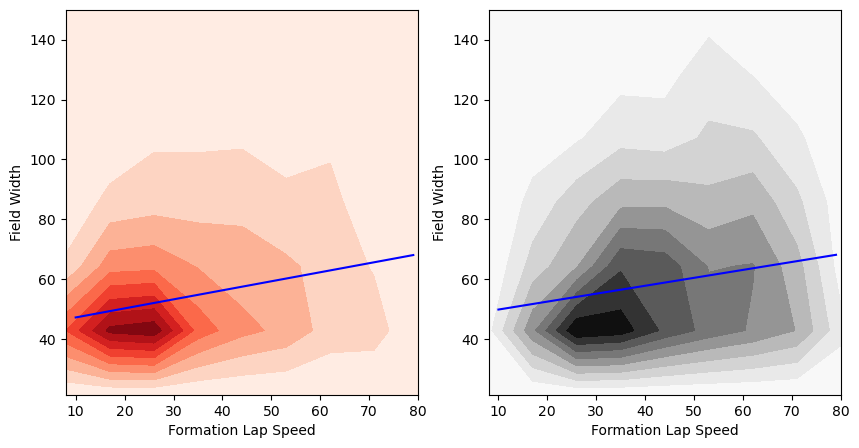

In [45]:
ttype= 'fam'
day = 0
for ttype in ['fam', 'nov']:

    ddf = df[(df['ttype']==ttype) * (df['day']==day) * (df['fwhm']<300) * (df['speed']<80) * (df['speed']>0)]
    model = smf.mixedlm('width ~ speed*C(cond)', ddf, groups = 'mouse').fit()
    model = smf.mixedlm('width ~ speed*C(cond)', ddf, groups = 'mouse').fit(start_params=model.params)
    print(model.summary())

    shift, speed, ledge = [], [], []
    for mouse in ko_mice:

        field_info = np.array(field_stats[mouse][day][ttype]['field_info'])

        # shift.append(10*field_stats[mouse][day][ttype]['fwhm'])
        shift.append(10*field_info[:,2])
        speed.append(np.array(field_info)[:,-2])
        ledge.append(field_info[:,1])

    shift = np.concatenate(shift)
    speed = np.concatenate(speed)
    ledge = np.concatenate(ledge)

    # print(shift.shape)

    mask = ~np.isnan(shift) & (shift>-50) & (speed>5) & (shift<300) & (speed<80) & (ledge>0)
    
    
    fig, ax = plt.subplots(1,2,figsize=[10,5]) #,sharey=True, sharex=True, )
    speed_bins = np.linspace(-1, 80, num=10)
    # shift_bins = np.linspace(-30,80, num=15)
    shift_bins = np.linspace(0,150, num=8)
    X,Y = np.meshgrid(speed_bins[1:], shift_bins[1:])
    # ax[0].scatter(speed[mask], shift[mask], color ='red', s=2, alpha=.3)
    # ax[0].plot(speed_bins, 0*speed_bins, color='blue')

    H, _, _ = np.histogram2d(speed[mask], shift[mask], bins = [speed_bins,shift_bins], density=True)
    H_ko =np.copy(H)
    H_ko = H_ko/(H_ko.sum(axis=1, keepdims=True)+1E-3)
    print(H.shape)
    # ax[0].imshow((H/(H.sum(axis=1,keepdims=True)+1E-3)).T, vmin=0, vmax=.2, cmap='Reds')
    ax[0].contourf(X, Y, H_ko.T, 10, cmap='Reds')
    # ax[0].hist2d(speed[mask], shift[mask], bins=[speed_bins, shift_bins], cmap='PuRd', density=True, vmax=.01)
    r,p = sp.stats.pearsonr(speed[mask], shift[mask])
    print(f"cre r: {r}, p: {p}")
    # print(res)

    shift, speed, ledge = [], [], []
    for mouse in ctrl_mice:

        field_info = np.array(field_stats[mouse][day][ttype]['field_info'])

        # shift.append(10*field_stats[mouse][day][ttype]['fwhm'])
        shift.append(10*field_info[:,2])
        speed.append(np.array(field_info)[:,-2])
        ledge.append(field_info[:,1])

    shift = np.concatenate(shift)
    speed = np.concatenate(speed)
    ledge = np.concatenate(ledge)

    # print(shift.shape)

    mask = ~np.isnan(shift) & (shift>-50) & (speed>5) & (shift<300) & (speed<80) & (ledge>0)
    H, _, _ = np.histogram2d(speed[mask], shift[mask], bins = [speed_bins,shift_bins], density=True)
    H_ctrl = np.copy(H)
    H_ctrl = H_ctrl/(H_ctrl.sum(axis=1, keepdims=True)+1E-3)

    ax[1].contourf(X, Y, H_ctrl.T, 10, cmap='Greys')

    r,p = sp.stats.pearsonr(speed[mask], shift[mask])
    print(f"control r: {r}, p: {p}")

    trials = np.arange(10,80)
    y_cre = model.params['Intercept'] + model.params['speed']*trials
    y_ctrl = model.params['Intercept'] + model.params['C(cond)[T.ctrl]'] + (model.params['speed']+model.params['speed:C(cond)[T.ctrl]'])*trials 
    
    print(f"control int: {model.params['Intercept']+model.params['C(cond)[T.ctrl]']}, slope: {model.params['speed']+model.params['speed:C(cond)[T.ctrl]']}")
    print(f"cre int: {model.params['Intercept']}, slope: {model.params['speed']}")
    ax[0].plot(trials, y_cre, color='blue')
    # ax[0].plot(trials, y_ctrl, color='black')

    ax[0].set_xlabel('Formation Lap Speed')
    ax[0].set_ylabel('Field Width')

    # ax[1].plot(trials, y_cre, color='red')
    ax[1].plot(trials, y_ctrl, color='blue')

    ax[1].set_xlabel('Formation Lap Speed')
    ax[1].set_ylabel('Field Width')
    
    fig.savefig(os.path.join(figdir, f"width_vs_speed_day0_{ttype}.pdf"))




In [19]:
np.arange(10,70,10)

array([10, 20, 30, 40, 50, 60])

In [20]:
df = {'mouse':[], 'cond': [], 'ttype': [], 'day':[], 'shift': [], 'width': [], 'speed_bin': []}

speed_bin_edges = np.arange(10, 65, 10)
for t, ttype in enumerate(('fam', 'nov')):
    for day in range(6):
        
        for cond, mice in {'ctrl': ctrl_mice, 'ko': ko_mice}.items():
            for mouse in mice:
                field_info =  np.array(field_stats[mouse][day][ttype]['field_info'])
                
                mask = (field_info[:,1]>0 ) #* (field_info[:,1]+field_info[:,2] <29)
                if mask.sum()>0:
                
                    com = field_stats[mouse][day][ttype]['com'][:, mask]
                    com = com - np.nanmean(com[1:,:],axis=0, keepdims=True)
                    shift = com[0,:]*10.

                    width = 10*field_info[mask,2]


                    speed = field_info[mask,4]


                    speed_bin_inds = np.digitize(speed, speed_bin_edges)
                    for speed_bin in range(1,len(speed_bin_edges)):
                        speed_mask = speed_bin_inds==speed_bin
                        if speed_mask.sum()>0:
                            
                            # shift_bin = np.nanmean(shift[speed_mask])
                            # width_bin = np.nanmean(width[speed_mask])
                            
                            shift_bin = shift[speed_mask]
                            width_bin = width[speed_mask]
                            
                            for _s, _w in zip(shift_bin.tolist(), width_bin.tolist()):
                                df['mouse'].append(mouse)
                                df['cond'].append(cond)
                                df['ttype'].append(ttype)
                                df['day'].append(day)
                                df['speed_bin'].append(speed_bin)
                                df['shift'].append(_s)
                                df['width'].append(_w)

#                             df['mouse'].append(mouse)
#                             df['cond'].append(cond)
#                             df['ttype'].append(ttype)
#                             df['day'].append(day)
#                             df['speed_bin'].append(speed_bin)
#                             df['shift'].append(shift_bin)
#                             df['width'].append(width_bin)
                    
df = pd.DataFrame(df)


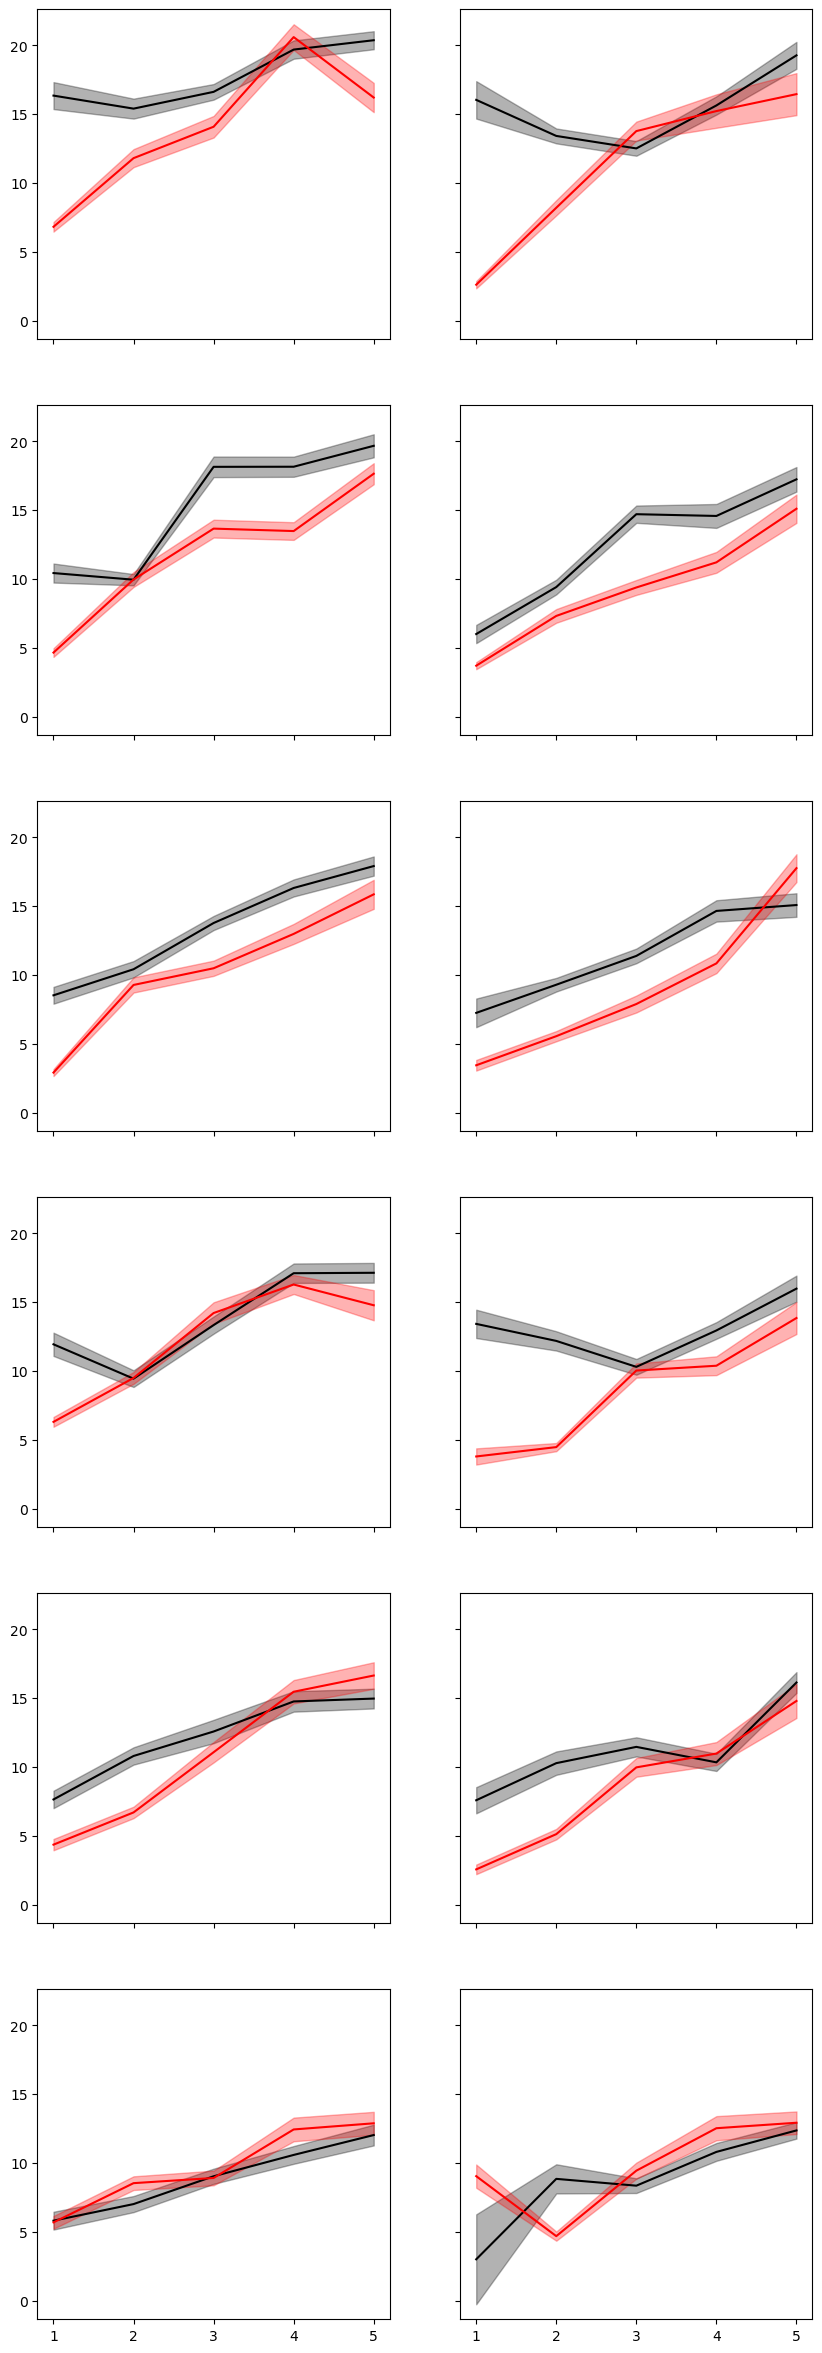

In [21]:
fig,ax = plt.subplots(6,2, figsize = [10, 30], sharey=True, sharex=True)

mask = (df['cond']=='ctrl') * (df['ttype']=='nov')
for day in range(6):
    _df = df[mask * (df['day']==day)]
    x = np.unique(_df['speed_bin'])
    mu, sem = [], []
    for _x in x:
        _df_s = _df[_df['speed_bin']==_x]
        
        mu.append(np.nanmean(_df_s['shift']))
        sem.append(sp.stats.sem(_df_s['shift'], nan_policy='omit'))
        
    mu = np.array(mu)
    sem = np.array(sem)
    ax[day,0].fill_between(x, mu-sem, mu+sem, color='black', alpha=.3)
    ax[day,0].plot(x, mu, color='black')
    
    
mask = (df['cond']=='ko') * (df['ttype']=='nov')
for day in range(6):
    _df = df[mask * (df['day']==day)]
    x = np.unique(_df['speed_bin'])
    mu, sem = [], []
    for _x in x:
        _df_s = _df[_df['speed_bin']==_x]
        
        mu.append(np.nanmean(_df_s['shift']))
        sem.append(sp.stats.sem(_df_s['shift'], nan_policy='omit'))
        
    mu = np.array(mu)
    sem = np.array(sem)
    ax[day,0].fill_between(x, mu-sem, mu+sem, color='red', alpha=.3)
    ax[day,0].plot(x, mu, color='red')
    
mask = (df['cond']=='ctrl') * (df['ttype']=='fam')
for day in range(6):
    _df = df[mask * (df['day']==day)]
    x = np.unique(_df['speed_bin'])
    mu, sem = [], []
    for _x in x:
        _df_s = _df[_df['speed_bin']==_x]
        
        mu.append(np.nanmean(_df_s['shift']))
        sem.append(sp.stats.sem(_df_s['shift'], nan_policy='omit'))
        
    mu = np.array(mu)
    sem = np.array(sem)
    ax[day,1].fill_between(x, mu-sem, mu+sem, color='black', alpha=.3)
    ax[day,1].plot(x, mu, color='black')
    
    
mask = (df['cond']=='ko') * (df['ttype']=='fam')
for day in range(6):
    _df = df[mask * (df['day']==day)]
    x = np.unique(_df['speed_bin'])
    mu, sem = [], []
    for _x in x:
        _df_s = _df[_df['speed_bin']==_x]
        
        mu.append(np.nanmean(_df_s['shift']))
        sem.append(sp.stats.sem(_df_s['shift'], nan_policy='omit'))
        
    mu = np.array(mu)
    sem = np.array(sem)
    ax[day, 1].fill_between(x, mu-sem, mu+sem, color='red', alpha=.3)
    ax[day,1].plot(x, mu, color='red')

0.20327034565017746 5.169330245441087e-66
0.24020678189936825 2.2827761460494695e-80
0.23086092955306922 2.2724123812241512e-82
0.31471295676529193 3.654151876648059e-129
0.37029909088127144 1.8371312929581346e-157
0.3733583617414586 1.474800032784075e-103
0.24985390796008103 2.508658981177117e-72
0.1826346603566794 1.5471321771203195e-49
0.19221522006802236 7.733525287189558e-53
0.2592206167901228 1.7111306550042694e-99
0.1904134214384934 1.385269795085792e-43
0.2549979654478978 4.108614949695432e-50
0.1455262541193934 2.201784236180572e-27
0.26883130225965457 9.821251244220903e-83
0.1622658067533511 5.934230766472335e-33
0.26397568312606556 6.539408858362766e-76
0.35315676324909845 1.2011614790900189e-123
0.35426972283973146 3.3955800502298112e-136
0.1244735113822688 1.011063918305714e-16
0.08285217357589356 9.901917044507807e-10
0.1947324475806199 2.212870576802777e-41
0.23273686907621782 1.4427200551029231e-69
0.11389898723178096 3.4123256439152743e-16
0.1507240108735502 2.29560369

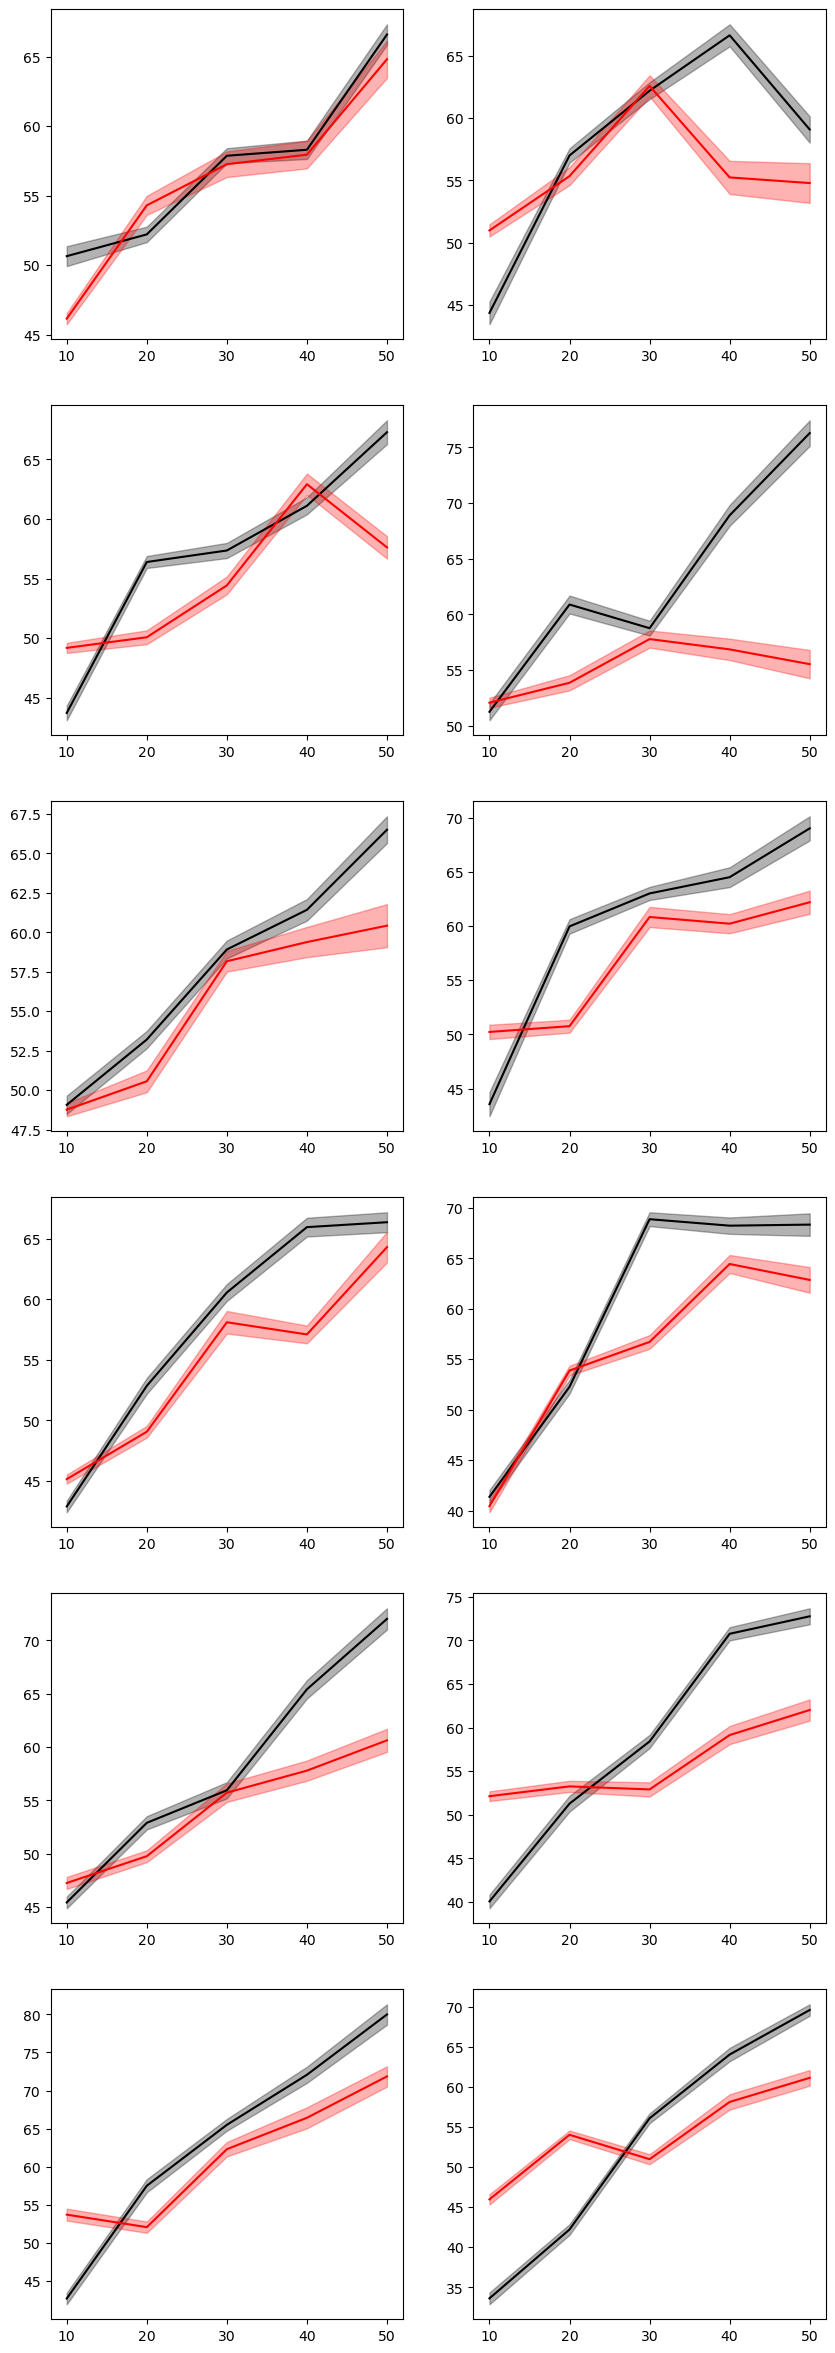

In [23]:
fig,ax = plt.subplots(6,2, figsize = [10, 30]) #, sharey=True, sharex=True)

mask = (df['cond']=='ctrl') * (df['ttype']=='nov')

for day in range(6):
    
    _df = df[mask * (df['day']==day)]
    r, p = sp.stats.pearsonr(_df['speed_bin'], _df['width'])
    print(r, p)
    
    
    x = np.unique(_df['speed_bin'])
    mu, sem = [], []
    for _x in x:
        _df_s = _df[_df['speed_bin']==_x]
        
        mu.append(np.nanmean(_df_s['width']))
        sem.append(sp.stats.sem(_df_s['width'], nan_policy='omit'))
        
    mu = np.array(mu)
    sem = np.array(sem)
    ax[day,0].fill_between(speed_bin_edges[:-1], mu-sem, mu+sem, color='black', alpha=.3)
    ax[day,0].plot(speed_bin_edges[:-1], mu,  color='black')
    
    
    
    
mask = (df['cond']=='ko') * (df['ttype']=='nov')
for day in range(6):
    _df = df[mask * (df['day']==day)]
    x = np.unique(_df['speed_bin'])
    mu, sem = [], []
    for _x in x:
        _df_s = _df[_df['speed_bin']==_x]
        
        mu.append(np.nanmean(_df_s['width']))
        sem.append(sp.stats.sem(_df_s['width'], nan_policy='omit'))
        
    mu = np.array(mu)
    sem = np.array(sem)
    ax[day,0].fill_between(speed_bin_edges[:-1], mu-sem, mu+sem, color='red', alpha=.3)
    ax[day,0].plot(speed_bin_edges[:-1], mu,  color='red')
    
    r, p = sp.stats.pearsonr(_df['speed_bin'], _df['width'])
    print(r, p)
    
mask = (df['cond']=='ctrl') * (df['ttype']=='fam')
for day in range(6):
    _df = df[mask * (df['day']==day)]
    x = np.unique(_df['speed_bin'])
    mu, sem = [], []
    for _x in x:
        _df_s = _df[_df['speed_bin']==_x]
        
        mu.append(np.nanmean(_df_s['width']))
        sem.append(sp.stats.sem(_df_s['width'], nan_policy='omit'))
        
    mu = np.array(mu)
    sem = np.array(sem)
    ax[day,1].fill_between(speed_bin_edges[:-1], mu-sem, mu+sem, color='black', alpha=.3)
    ax[day,1].plot(speed_bin_edges[:-1], mu, color='black')
    
    r, p = sp.stats.pearsonr(_df['speed_bin'], _df['width'])
    print(r, p)
    
    
mask = (df['cond']=='ko') * (df['ttype']=='fam')
for day in range(6):
    _df = df[mask * (df['day']==day)]
    x = np.unique(_df['speed_bin'])
    mu, sem = [], []
    for _x in x:
        _df_s = _df[_df['speed_bin']==_x]
        
        mu.append(np.nanmean(_df_s['width']))
        sem.append(sp.stats.sem(_df_s['width'], nan_policy='omit'))
        
    mu = np.array(mu)
    sem = np.array(sem)
    ax[day, 1].fill_between(speed_bin_edges[:-1], mu-sem, mu+sem, color='red', alpha=.3)
    ax[day,1].plot(speed_bin_edges[:-1], mu, color='red')
    
    r, p = sp.stats.pearsonr(_df['speed_bin'], _df['width'])
    print(r, p)

In [62]:
ddf = df[ (df['day']==0) * (df['cond']=='ctrl') ]
model = smf.ols('width ~ speed_bin*C(ttype)', ddf).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  width   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     116.8
Date:                Mon, 25 Sep 2023   Prob (F-statistic):           1.16e-74
Time:                        00:42:42   Log-Likelihood:                -61742.
No. Observations:               13202   AIC:                         1.235e+05
Df Residuals:                   13198   BIC:                         1.235e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    51.0755      0.914     55.857      0.000      49.283      52.868
C(ttype)[T.nov]              -3.2839      1.268     -2.591      0.010      -5.769      -0.799
speed_bin                     3.4369      0.293     11.715      0.000       2.862       4.012
speed_bin:C(ttype)[T.nov]     0.1997      0.392      0.510      0.610      -0.568       0.967
==============================================================================
Omnibus:                     1207.985   Durbin-Watson:                   1.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1571.505
Skew:                           0.843   Prob(JB):                         0.00
Kurtosis:                       3.116   Cond. No.                         26.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

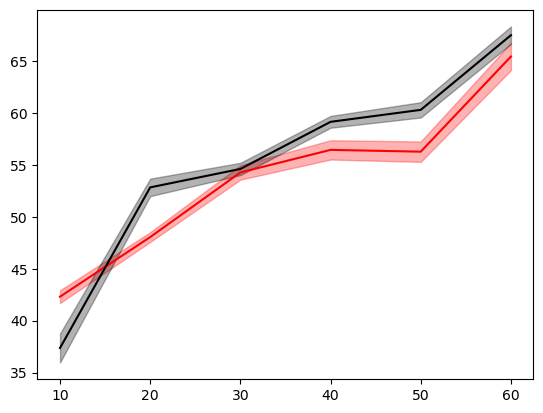

In [63]:
ttype= 'nov'
day = 0



shift, speed = [], []
for mouse in ko_mice:

    field_info = np.array(field_stats[mouse][day][ttype]['field_info'])
    
    mask = field_info[:,1]>0 
    shift.append(10*field_info[mask,2])

    
    speed.append(np.array(field_info)[mask,-2])

shift = np.concatenate(shift)
speed = np.concatenate(speed)


speed_bin_edges = np.arange(10, 71, 10)
ko_bin_inds = np.digitize(speed, speed_bin_edges)
ko_mu, ko_sem = [], []
for i in range(speed_bin_edges.shape[0]-1):
    mask = ko_bin_inds==i 
    _shift = shift[mask]
    ko_mu.append(np.nanmean(_shift))
    ko_sem.append(sp.stats.sem(_shift, nan_policy='omit'))
ko_mu = np.array(ko_mu)
ko_sem = np.array(ko_sem)
    

fig,ax = plt.subplots()
ax.fill_between(speed_bin_edges[:-1], ko_mu-ko_sem, ko_mu+ko_sem, color='red', alpha=.3)
ax.plot(speed_bin_edges[:-1], ko_mu, color='red')


shift, speed = [], []
for mouse in ctrl_mice:

    field_info = np.array(field_stats[mouse][day][ttype]['field_info'])
   
    mask = field_info[:,1]>0
    shift.append(10*field_info[mask,2])

    speed.append(np.array(field_info)[mask,-2])

shift = np.concatenate(shift)
speed = np.concatenate(speed)





ctrl_bin_inds = np.digitize(speed, speed_bin_edges)
ctrl_mu, ctrl_sem = [], []
for i in range(speed_bin_edges.shape[0]-1):
    mask = ctrl_bin_inds==i 
    _shift = shift[mask]
    ctrl_mu.append(np.nanmean(_shift))
    ctrl_sem.append(sp.stats.sem(_shift, nan_policy='omit'))
ctrl_mu = np.array(ctrl_mu)
ctrl_sem = np.array(ctrl_sem)
    

ax.fill_between(speed_bin_edges[:-1], ctrl_mu-ctrl_sem, ctrl_mu+ctrl_sem, color='black', alpha=.3)
ax.plot(speed_bin_edges[:-1], ctrl_mu, color='black')


In [ ]:
# fig, ax = plt.subplots()
ax.scatter(speed, shift)
res = sp.stats.linregress(speed, shift)
print(res)

In [162]:
df.head

<bound method NDFrame.head of             mouse  cond ttype  day     shift      speed
0       4467331.1  ctrl   nov    0  2.026325  49.749644
1       4467331.1  ctrl   nov    0  0.760758  49.044837
2       4467331.1  ctrl   nov    0  1.991123  46.304698
3       4467331.1  ctrl   nov    0  0.246813  45.543564
4       4467331.1  ctrl   nov    0 -2.809353  48.303798
...           ...   ...   ...  ...       ...        ...
121933       Cre9   cre   fam    5  4.305235  41.347871
121934       Cre9   cre   fam    5  1.135960  10.795451
121935       Cre9   cre   fam    5  3.489809  11.142558
121936       Cre9   cre   fam    5  1.103631   9.744437
121937       Cre9   cre   fam    5  3.357128  37.853484

[121938 rows x 6 columns]>

In [ ]:
# slope for shift over trials after formation lap

In [ ]:
#                 fig, ax = plt.subplots(1,5, figsize = [8,4], sharey=True)
#                 # formation_lap = formation_lap[0]
#                 # print(formation_lap)

#                 ax[0].imshow(sess.trial_matrices['spks'][trial_mask, :, _ledge[1]], cmap='magma', aspect = 'auto')
#                 ax[1].imshow(sess.trial_matrices['spks'][trial_mask, _ledge[0]:_ledge[0]+_redge[0][0], _ledge[1]], cmap='magma', aspect = 'auto')

#                 ax[2].imshow(place_field_filt, cmap='magma', aspect='auto')

#                 # ax[3].plot(place_field_bool, np.arange(place_field.shape[0]))
#                 # ax[3].plot(place_field_bin_counts,np.arange(place_field_bin_counts.shape[0]))
#                 ax[3].plot(field_strength[formation_lap:], np.arange(formation_lap, place_field.shape[0]))

#                 com = np.nansum(place_field*np.arange(place_field.shape[1])[np.newaxis,:], axis=-1)/(np.nansum(place_field,axis=-1)+1E-5)
#                 # com = np.array([sp.ndimage.center_of_mass(place_field[t, :]) for t in range(formation_lap, place_field.shape[0])])
#                 ax[4].plot(com[formation_lap:], np.arange(formation_lap, place_field.shape[0]))
#                 fig.suptitle(f'{thresh_active_laps[0]}')


# field_info = np.array(field_info)
com_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
fs_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])

for i, field in enumerate(field_info):
    
    field_mat = sess.trial_matrices['spks'][trial_mask, field[1]:field[2], field[0]]
    field_mat = field_mat[field[3]:,:]
    
    fs = np.nanmean(field_mat,axis=-1)
    com = np.nansum(field_mat*np.arange(field_mat.shape[1])[np.newaxis,:], axis=-1)/(np.nansum(field_mat, axis=-1) + 1E-5)/(field_mat.shape[1]-1)
    
    com_mat[:com.shape[0],i] = com
    fs_mat[:fs.shape[0], i] = fs
    
    
fig, ax = plt.subplots()    
mu, sem = np.nanmean(com_mat, axis=-1), sp.stats.sem(com_mat, axis=-1, nan_policy='omit')
# max_trial = 10
ax.fill_between(np.arange(5), mu[:5]+sem[:5], mu[:5]-sem[:5], alpha=.3)
ax.plot(np.nanmean(com_mat[:5,:], axis=-1))
    

    # print(_ledge)

# find fields >= 30 cm
# ledges = 
# print(sig_bins.shape)

In [87]:
field_info.shape



(47, 4)

In [7]:
trial_mat_thresh = np.nanpercentile(shuff_trial_mat,95,axis=0)
trial_mat_thresh.shape

(30, 1381)

In [8]:
np.save('place_field_shuff_results.npy', shuff_trial_mat)

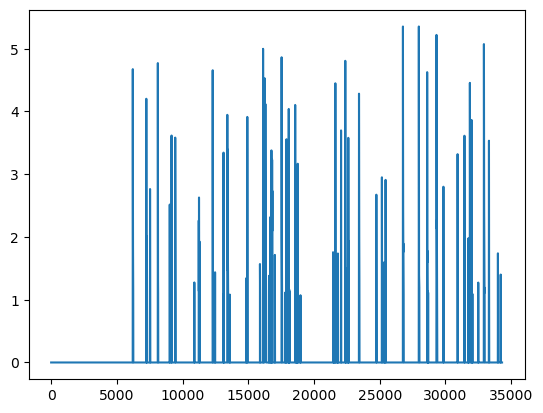

In [19]:
fig, ax = plt.subplots()
ax.plot(spks_shuff[0,:])